In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data_lag_n = pd.read_csv("../../data/processed/pagos_por_unidad.csv",
                  dtype = {
                                "unidad_id": "object",
                            },
                  parse_dates = ["expensa_mes_pago"])

In [3]:
data = pd.read_csv("../../data/processed/expensas_full_processed_vis.csv",
                  dtype = {
                                "expensa_id": "object",
                                "unidad_id": "object",
                                "consorcio_id": "object",
                                "expensa_mes":"object",
                            },
                  parse_dates = ["expensa_fecha", "expensa_mes_pago", "expensa_mes_pago_anterior"])

In [4]:
data.dtypes

expensa_id                                      object
consorcio_id                                    object
consorcio_nombre                                object
consorcio_cantidad_expensas                    float64
consorcio_prop_impagos                         float64
consorcio_prop_efectivo                        float64
unidad_id                                       object
unidad_denominacion                             object
unidad_tipo                                     object
expensa_proporcion                             float64
expensa_interes_primer_vencimiento             float64
expensa_ineteres_segundo_vencimiento           float64
expensa_mes                                     object
expensa_fecha                           datetime64[ns]
expensa_mes_pago                        datetime64[ns]
pago_metodo                                     object
target                                         float64
expensa_mes_pago_anterior               datetime64[ns]
dtype: obj

In [5]:
final_data = pd.merge(
    data[["expensa_id", "unidad_id", "unidad_tipo", "expensa_mes", "expensa_mes_pago"]],
    data_lag_n,
    left_on = ["unidad_id", "expensa_mes_pago"],
    right_on = ["unidad_id", "expensa_mes_pago"],
    how = "inner"
)

In [6]:
final_data.shape

(168955, 12)

In [7]:
final_data["target_lag_1"] = final_data.pago_metodo_lag_1 == "Impago"

In [8]:
data_lag_n.shape

(168955, 9)

In [9]:
final_data.columns

Index(['expensa_id', 'unidad_id', 'unidad_tipo', 'expensa_mes',
       'expensa_mes_pago', 'pago_metodo_lag_6', 'pago_metodo_lag_5',
       'pago_metodo_lag_4', 'pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1', 'target', 'target_lag_1'],
      dtype='object')

In [10]:
model_columns_6 = ['unidad_tipo', 'expensa_mes', 'pago_metodo_lag_6', 'pago_metodo_lag_5',
       'pago_metodo_lag_4', 'pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1'] 
model_columns = ['unidad_tipo', 'expensa_mes', 'pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1'] 

final_data = final_data.sort_values("expensa_mes_pago").reset_index().drop(columns="index")
min_cv_id = final_data.loc[final_data.expensa_mes_pago == "2018-06-01", "expensa_mes_pago"].idxmin()
min_test_id = final_data.loc[final_data.expensa_mes_pago == "2018-09-01", "expensa_mes_pago"].idxmin()

In [11]:
def get_train_test_split(X_columns):
    X_train = pd.get_dummies(final_data.loc[0:min_test_id, X_columns], drop_first=True)
    X_test = pd.get_dummies(final_data.loc[min_test_id:, X_columns], drop_first=True)
    Y_train = final_data.loc[0:min_test_id, "target"]
    Y_test = final_data.loc[min_test_id:, "target"]
      
    drop_test_columns = [column for column in X_test.columns if column not in X_train.columns]
    X_test = X_test.drop(columns=drop_test_columns)

    for column in [column for column in X_train.columns if column not in X_test.columns]:
        X_test[column] = 0
    
    X_test = X_test[X_train.columns]
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    return X_train, Y_train, X_test, Y_test

In [12]:
X_train, Y_train, X_test, Y_test = get_train_test_split( model_columns )

(131848, 31) (131848,)
(37108, 31) (37108,)


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_train_test_meassures(model, X_train, Y_train, X_test, Y_test):
    train_preds = model.predict(X_train)
    print("accuracy:", accuracy_score(Y_train, train_preds))
    print("precision:", precision_score(Y_train, train_preds))
    print("recall:", recall_score(Y_train, train_preds))
    print("f1:", f1_score(Y_train, train_preds))
    print("--------------------------------------------------")
    test_preds = model.predict(X_test)
    print("accuracy:", accuracy_score(Y_test, test_preds))
    print("precision:", precision_score(Y_test, test_preds))
    print("recall:", recall_score(Y_test, test_preds))
    print("f1:", f1_score(Y_test, test_preds))

In [14]:
def get_logReg_coef(model, columns):
    lm_coef = pd.DataFrame({
        "variable": columns,
        "coef": model.coef_[0]
    })

    lm_coef["abs_coef"] = abs(lm_coef.coef)

    from pandas.api.types import CategoricalDtype
    lm_coef = lm_coef.sort_values("abs_coef", ascending = False)
    lm_coef = lm_coef.reset_index().drop(columns="index")

    variable_cat = CategoricalDtype(categories=lm_coef.variable, ordered=True)
    lm_coef.variable = lm_coef.variable.astype(variable_cat)

    figure_size = (16, 4.8)
    return (ggplot(data=lm_coef)
        + geom_bar(aes(x = "variable",y="coef"), stat = "identity", fill = "#5DADE2")
        + theme(
            axis_text_x = element_text(angle = 45, hjust = 1),
            figure_size = (16, 4.5),
            panel_background = element_rect(fill = "white"),
            panel_grid = element_line(color="grey", linetype="dashed", size=0.5)
        )
        + ggtitle("Coeficientes de Analisis Discriminante Lineal")
        + ylab("Valor del Coeficiente")
        + xlab("Variable")
    )

## Modelo Naive

In [15]:
from sklearn.linear_model import LogisticRegression
X_train_naive, Y_train, X_test_naive, Y_test = get_train_test_split(["target_lag_1"])
naive = LogisticRegression(
    C = 1000000,
    solver = "lbfgs",
    penalty = "l2",
    max_iter = 100,
)
naive.fit(X_train_naive, Y_train) 
get_train_test_meassures(naive, X_train_naive, Y_train, X_test_naive, Y_test)

(131848, 1) (131848,)
(37108, 1) (37108,)
accuracy: 0.8660578848370851
precision: 0.7510658324566746
recall: 0.7578635677970836
f1: 0.7544493882091211
--------------------------------------------------
accuracy: 0.8635604182386547
precision: 0.7054009819967266
recall: 0.7035093855660487
f1: 0.7044539139571536


## Regresion Logistica

In [16]:
X_train, Y_train, X_test, Y_test = get_train_test_split( ['unidad_tipo', 'expensa_mes','pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1'] )

logReg = LogisticRegression(
    C = 1000000,
    solver = "lbfgs",
    penalty = "l2",
    max_iter = 200,
)
logReg.fit(X_train, Y_train) 
get_train_test_meassures(logReg, X_train, Y_train, X_test, Y_test)

(131848, 31) (131848,)
(37108, 31) (37108,)
accuracy: 0.8784509435107093
precision: 0.8080134596211366
recall: 0.7244538801050338
f1: 0.7639555778124724
--------------------------------------------------
accuracy: 0.8795946965613883
precision: 0.7664375567371288
recall: 0.6890521161245191
f1: 0.7256876227897839


In [17]:
get_logReg_coef(logReg, X_train.columns)

NameError: name 'get_logReg_coef' is not defined

In [ ]:
import pickle

with open('../../models/finales/logisticRegression.pkl', 'wb') as file:
    pickle.dump(logReg, file)

## LDA

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

param_grid = {
    "solver": ["svd", "lsqr", "eigen"],
    "shrinkage": [None, "auto"]
}

lda = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = param_grid,
    scoring = 'f1',
    n_jobs = -1,
    cv = [(list(range(0,min_cv_id)), list(range(min_cv_id,min_test_id)))],
    return_train_score = True,
    error_score = 0,
    verbose = 5
)

In [19]:
lda.fit(X_train.values, Y_train.values)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.7s finished
C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...4, 131835, 131836, 131837, 131838, 131839, 131840, 131841, 131842, 131843, 131844, 131845, 131846])],
       error_score=0,
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': [None, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=5)

In [128]:
lda.best_params_

{'shrinkage': 'auto', 'solver': 'lsqr'}

In [20]:
get_train_test_meassures(lda, X_train, Y_train, X_test, Y_test)

accuracy: 0.8751744432983436
precision: 0.7872675420355297
recall: 0.7402927537851277
f1: 0.7630578750359919
--------------------------------------------------
accuracy: 0.8787592971865905
precision: 0.7566070979108985
recall: 0.7009443861490031
f1: 0.7277128850692973


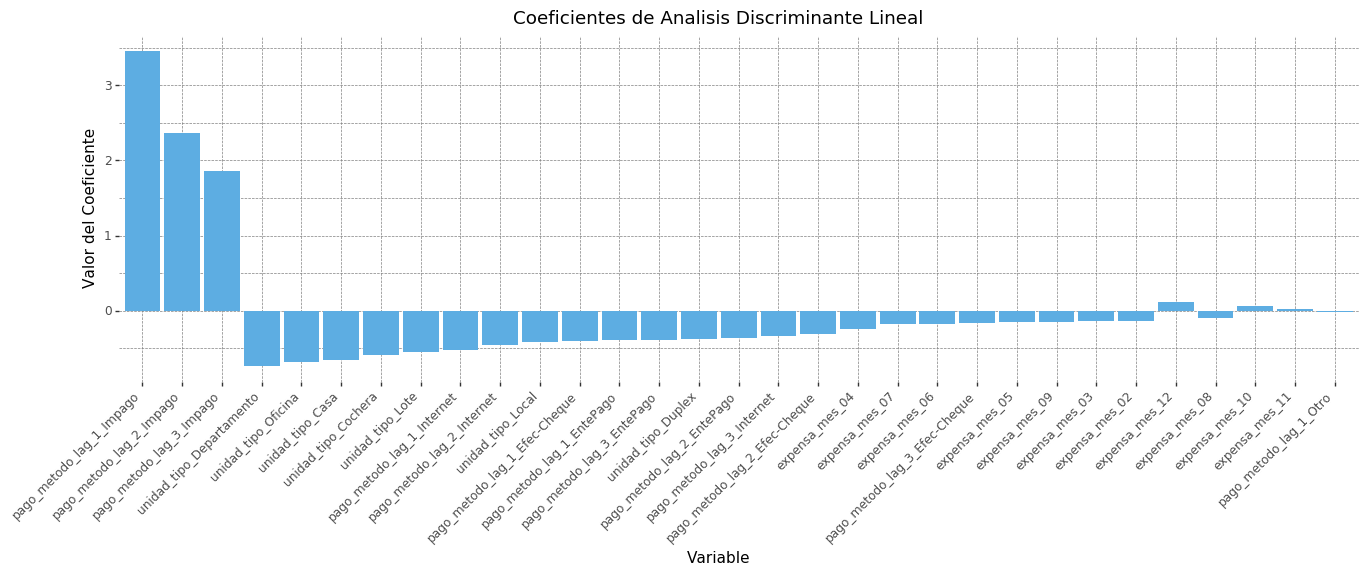

<ggplot: (159864983486)>

In [31]:
get_logReg_coef(lda.best_estimator_, X_train.columns)

## QDA

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

param_grid = {
    "reg_param": np.arange(0.,1., 0.1)
}

qda = GridSearchCV(
    estimator = QuadraticDiscriminantAnalysis(),
    param_grid = param_grid,
    scoring = 'f1',
    n_jobs = -1,
    cv = [(list(range(0,min_cv_id)), list(range(min_cv_id,min_test_id)))],
    return_train_score = True,
    error_score = 0,
    verbose = 5
)

In [37]:
qda.fit(X_train.values, Y_train.values)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.5s finished
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...4, 131835, 131836, 131837, 131838, 131839, 131840, 131841, 131842, 131843, 131844, 131845, 131846])],
       error_score=0,
       estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'reg_param': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=5)

In [39]:
qda.best_params_

{'reg_param': 0.2}

In [38]:
get_train_test_meassures(qda, X_train, Y_train, X_test, Y_test)

accuracy: 0.8736802985255749
precision: 0.7757230095633137
recall: 0.7522556495991508
f1: 0.7638091186272423
--------------------------------------------------
accuracy: 0.8786784520858036
precision: 0.7550381774940543
recall: 0.7032762038008628
f1: 0.7282385609078836


In [40]:
qda.best_estimator_.covariances_

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function covariances_ is deprecated; Attribute ``covariances_`` was deprecated in version 0.19 and will be removed in 0.21. Use ``covariance_`` instead
  warnings.warn(msg, category=DeprecationWarning)


AttributeError: 'QuadraticDiscriminantAnalysis' object has no attribute 'covariance_'

## SVC

In [56]:
from sklearn.svm import SVC

svc = SVC(
    C = 1e-06, 
    gamma = 1e-06,
    kernel = 'rbf'
)

In [57]:
svc.fit(X_train.values, Y_train.values)

SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
get_train_test_meassures(svc, X_train, Y_train, X_test, Y_test)

accuracy: 0.7284903828651174
precision: 0.0
recall: 0.0
f1: 0.0
--------------------------------------------------


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 0.7688638568502749
precision: 0.0
recall: 0.0
f1: 0.0


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### XGB

In [35]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_spaces = {
    "max_depth":Integer(2,5),
    "learning_rate": Real(1e-5, 1e-1, prior="log-uniform"),
    "n_estimators": Integer(500,2000),
    "reg_alpha": Real(0.01, 0.99, prior="log-uniform"),
}

xgb = BayesSearchCV(
    estimator = XGBClassifier(),
    search_spaces = search_spaces,
    n_iter = 20,
    scoring = 'f1',
    n_jobs = 1,
    cv = [(list(range(0,min_cv_id)), list(range(min_cv_id,min_test_id)))],
    return_train_score = True,
    error_score = 0,
    random_state = 42,
    verbose = 5,
    refit = True
)

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [66]:
xgb.fit(X_train.values, Y_train.values)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.0004369339947510315, max_depth=4, n_estimators=1899, reg_alpha=0.042679643506428916 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0004369339947510315, max_depth=4, n_estimators=1899, reg_alpha=0.042679643506428916, score=0.723404255319149, total= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.022364202820542706, max_depth=5, n_estimators=955, reg_alpha=0.7912175393539047 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.022364202820542706, max_depth=5, n_estimators=955, reg_alpha=0.7912175393539047, score=0.7267320844484092, total= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.0006016307829589929, max_depth=5, n_estimators=657, reg_alpha=0.07324436031030704 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0006016307829589929, max_depth=5, n_estimators=657, reg_alpha=0.07324436031030704, score=0.7229662202678393, total=  47.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.017765766649807682, max_depth=3, n_estimators=1397, reg_alpha=0.39996837195703283 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.017765766649807682, max_depth=3, n_estimators=1397, reg_alpha=0.39996837195703283, score=0.7231061743220255, total= 1.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.015783879853890563, max_depth=3, n_estimators=1290, reg_alpha=0.26810355649468604 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.015783879853890563, max_depth=3, n_estimators=1290, reg_alpha=0.26810355649468604, score=0.7230338202921753, total=  55.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.008632012725909877, max_depth=5, n_estimators=745, reg_alpha=0.023769943191685485 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.008632012725909877, max_depth=5, n_estimators=745, reg_alpha=0.023769943191685485, score=0.7237828651404579, total=  52.9s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.0029397976202716882, max_depth=4, n_estimators=1039, reg_alpha=0.555692238466896 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0029397976202716882, max_depth=4, n_estimators=1039, reg_alpha=0.555692238466896, score=0.723404255319149, total=  59.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.0014914622679778671, max_depth=5, n_estimators=1245, reg_alpha=0.4695227787561414 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0014914622679778671, max_depth=5, n_estimators=1245, reg_alpha=0.4695227787561414, score=0.7254784688995215, total= 1.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.06636085077612337, max_depth=4, n_estimators=1807, reg_alpha=0.0675814019852144 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.06636085077612337, max_depth=4, n_estimators=1807, reg_alpha=0.0675814019852144, score=0.7227518427518428, total= 1.7min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=1.0340016434251915e-05, max_depth=4, n_estimators=1612, reg_alpha=0.0322104977416997 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=1.0340016434251915e-05, max_depth=4, n_estimators=1612, reg_alpha=0.0322104977416997, score=0.7298017164841669, total= 1.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=1.1372103256807968e-05, max_depth=2, n_estimators=547, reg_alpha=0.013144407628901428 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=1.1372103256807968e-05, max_depth=2, n_estimators=547, reg_alpha=0.013144407628901428, score=0.7078240885824715, total=  17.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=1e-05, max_depth=5, n_estimators=2000, reg_alpha=0.99 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=1e-05, max_depth=5, n_estimators=2000, reg_alpha=0.99, score=0.723404255319149, total= 2.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.09643395173126594, max_depth=5, n_estimators=1998, reg_alpha=0.01158380718003116 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.09643395173126594, max_depth=5, n_estimators=1998, reg_alpha=0.01158380718003116, score=0.7221515892420539, total= 2.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.02199388848943524, max_depth=2, n_estimators=1987, reg_alpha=0.9557797519273585 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.02199388848943524, max_depth=2, n_estimators=1987, reg_alpha=0.9557797519273585, score=0.7301587301587301, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.1, max_depth=5, n_estimators=2000, reg_alpha=0.99 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=5, n_estimators=2000, reg_alpha=0.99, score=0.7225274725274724, total= 1.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=1.9234070164690412e-05, max_depth=2, n_estimators=506, reg_alpha=0.9131103804669881 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=1.9234070164690412e-05, max_depth=2, n_estimators=506, reg_alpha=0.9131103804669881, score=0.7078240885824715, total=  17.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.04366690173210502, max_depth=2, n_estimators=1982, reg_alpha=0.013330437417196032 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.04366690173210502, max_depth=2, n_estimators=1982, reg_alpha=0.013330437417196032, score=0.7300529307978827, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=1.0149213609977433e-05, max_depth=5, n_estimators=1927, reg_alpha=0.014820798251656638 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=1.0149213609977433e-05, max_depth=5, n_estimators=1927, reg_alpha=0.014820798251656638, score=0.7229662202678393, total= 2.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.09700568606672452, max_depth=2, n_estimators=1982, reg_alpha=0.010121043506064352 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.09700568606672452, max_depth=2, n_estimators=1982, reg_alpha=0.010121043506064352, score=0.7260003942440371, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished
C:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] learning_rate=0.1, max_depth=5, n_estimators=2000, reg_alpha=0.99 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=5, n_estimators=2000, reg_alpha=0.99, score=0.7225274725274724, total= 1.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


BayesSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...2, 107333, 107334, 107335, 107336, 107337, 107338, 107339, 107340, 107341, 107342, 107343, 107344])],
       error_score=0,
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=20, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=F

In [68]:
xgb.best_params_

{'learning_rate': 0.02199388848943524,
 'max_depth': 2,
 'n_estimators': 1987,
 'reg_alpha': 0.9557797519273585}

In [36]:
xgb2 = XGBClassifier(
    learning_rate = 0.02199388848943524,
    max_depth = 2,
    n_estimators = 1987,
    reg_alpha = 0.9557797519273585)
xgb2.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02199388848943524,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1987, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0,
       reg_alpha=0.9557797519273585, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [37]:
get_train_test_meassures(xgb2, X_train, Y_train, X_test, Y_test)

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.8792624840725685
precision: 0.815669959030711
recall: 0.7174423152131404
f1: 0.763409378018875
--------------------------------------------------
accuracy: 0.8789748841220222
precision: 0.7760810810810811
recall: 0.6695814387314912
f1: 0.7189084308693748


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
features_importances = pd.DataFrame({
    "importancia": xgb2.feature_importances_,
    "variable": X_train.columns
})

In [75]:
def get_features_importances_plot(model, columns):
    features_importances = pd.DataFrame({
        "importancia": xgb2.feature_importances_,
        "variable": X_train.columns
    })
    
    from pandas.api.types import CategoricalDtype
    features_importances = features_importances.sort_values("importancia", ascending = False)
    features_importances = features_importances.reset_index().drop(columns="index")

    variable_cat = CategoricalDtype(categories=features_importances.variable, ordered=True)
    features_importances.variable = features_importances.variable.astype(variable_cat)

    figure_size = (16, 4.8)
    return (ggplot(data=features_importances)
        + geom_bar(aes(x = "variable",y="importancia"), stat = "identity", fill = "#5DADE2")
        + theme(
            axis_text_x = element_text(angle = 45, hjust = 1),
            figure_size = (16, 4.5),
            panel_background = element_rect(fill = "white"),
            panel_grid = element_line(color="grey", linetype="dashed", size=0.5)
        )
        + ggtitle("Importancia de las Variables")
        + ylab("Importancia")
        + xlab("Variable")
    )

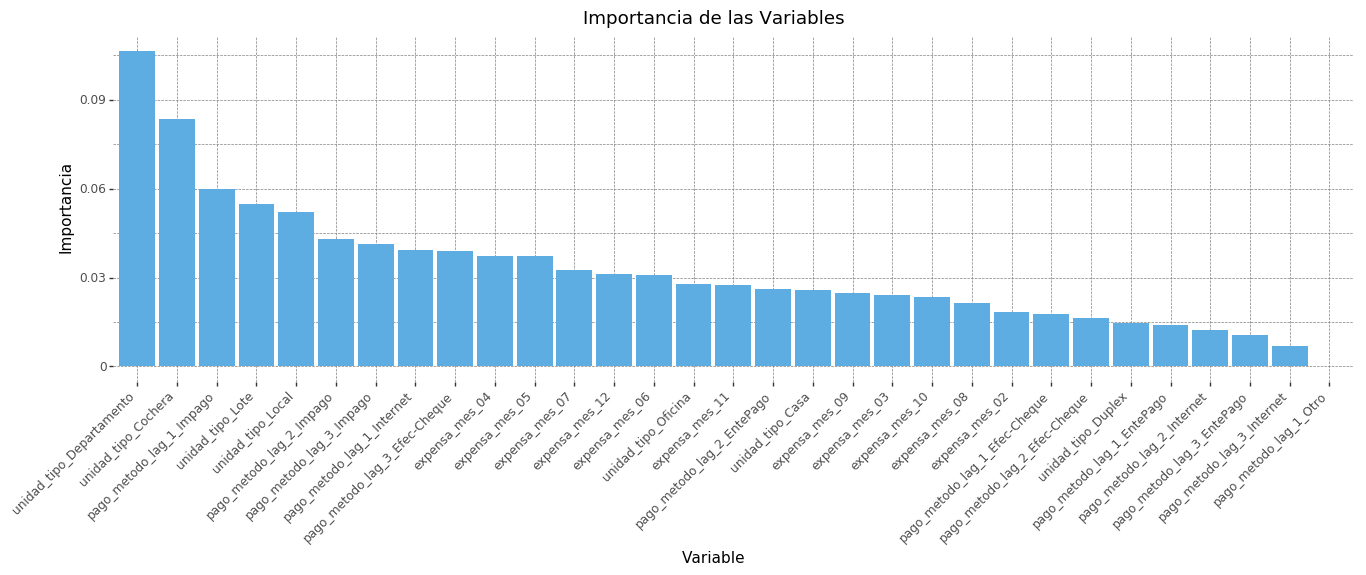

<ggplot: (-9223371950071537562)>

In [76]:
get_features_importances_plot(xgb2, X_train.columns)

In [78]:
with open('../../models/finales/xgb.pkl', 'wb') as file:
    pickle.dump(xgb2, file)

In [33]:
import pickle
with open('../../models/finales/xgb.pkl', 'rb') as file:
    xgb2 = pickle.load(file)

EOFError: Ran out of input

## Multi Layer Perceptron

In [45]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [42]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential
from keras.layers import LSTM, Embedding

batch_size =  5924
dropout = 0.629900496028121
epochs = 30
layer1 = 10
layer2 = 58
layer3 = 34

def create_model_mlpc(layer1=10, layer2=10, layer3=10, dropout=0.1):
    model = Sequential()
    model.add(Dense(layer1,input_dim=31, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(layer2, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(layer3, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc",f1])
    return model

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


X_train, Y_train, X_test, Y_test = get_train_test_split( ['unidad_tipo', 'expensa_mes','pago_metodo_lag_3', 'pago_metodo_lag_2',
       'pago_metodo_lag_1'] )

search_spaces = {
    "layer1": Integer(1,100),
    "layer2": Integer(1,100),
    "layer3": Integer(1,100),
    "dropout": Real(0,1),
    "epochs": Integer(5,100),
    "batch_size": Integer(50, 10000)
}

mlpc = BayesSearchCV(
    estimator = KerasClassifier(build_fn=create_model_mlpc, verbose=5),
    search_spaces = search_spaces,
    n_iter = 50,
    scoring = 'f1',
    n_jobs = 1,
    cv = [(list(range(0,min_cv_id)), list(range(min_cv_id,min_test_id)))],
    return_train_score = True,
    error_score = 0,
    random_state = 42,
    verbose = 5
)

Using TensorFlow backend.


(131848, 36) (131848,)
(37108, 36) (37108,)


NameError: name 'create_model_mlpc' is not defined

In [18]:
mlpc.fit(X_train.values, Y_train.values)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=4131, dropout=0.7277257431773251, epochs=94, layer1=32, layer2=67, layer3=42 
Epoch 1/94
Epoch 2/94
Epoch 3/94
Epoch 4/94
Epoch 5/94
Epoch 6/94
Epoch 7/94
Epoch 8/94
Epoch 9/94
Epoch 10/94
Epoch 11/94
Epoch 12/94
Epoch 13/94
Epoch 14/94
Epoch 15/94
Epoch 16/94
Epoch 17/94
Epoch 18/94
Epoch 19/94
Epoch 20/94
Epoch 21/94
Epoch 22/94
Epoch 23/94
Epoch 24/94
Epoch 25/94
Epoch 26/94
Epoch 27/94
Epoch 28/94
Epoch 29/94
Epoch 30/94
Epoch 31/94
Epoch 32/94
Epoch 33/94
Epoch 34/94
Epoch 35/94
Epoch 36/94
Epoch 37/94
Epoch 38/94
Epoch 39/94
Epoch 40/94
Epoch 41/94
Epoch 42/94
Epoch 43/94
Epoch 44/94
Epoch 45/94
Epoch 46/94
Epoch 47/94
Epoch 48/94
Epoch 49/94
Epoch 50/94
Epoch 51/94
Epoch 52/94
Epoch 53/94
Epoch 54/94
Epoch 55/94
Epoch 56/94
Epoch 57/94
Epoch 58/94
Epoch 59/94
Epoch 60/94
Epoch 61/94
Epoch 62/94
Epoch 63/94
Epoch 64/94
Epoch 65/94
Epoch 66/94
Epoch 67/94
Epoch 68/94
Epoch 69/94
Epoch 70/94
Epoch 71/94
Epoc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.6s finished


Epoch 1/34
Epoch 2/34
Epoch 3/34
Epoch 4/34
Epoch 5/34
Epoch 6/34
Epoch 7/34
Epoch 8/34
Epoch 9/34
Epoch 10/34
Epoch 11/34
Epoch 12/34
Epoch 13/34
Epoch 14/34
Epoch 15/34
Epoch 16/34
Epoch 17/34
Epoch 18/34
Epoch 19/34
Epoch 20/34
Epoch 21/34
Epoch 22/34
Epoch 23/34
Epoch 24/34
Epoch 25/34
Epoch 26/34
Epoch 27/34
Epoch 28/34
Epoch 29/34
Epoch 30/34
Epoch 31/34
Epoch 32/34
Epoch 33/34
Epoch 34/34


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s finished


[CV]  batch_size=8382, dropout=0.8833152773808622, epochs=34, layer1=95, layer2=87, layer3=7, score=0.0, total=  16.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=4476, dropout=0.9187225216693771, epochs=15, layer1=44, layer2=20, layer3=46 
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  batch_size=4476, dropout=0.9187225216693771, epochs=15, layer1=44, layer2=20, layer3=46, score=0.0, total=   6.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=8133, dropout=0.1718715613965607, epochs=62, layer1=80, layer2=53, layer3=10 
Epoch 1/62
Epoch 2/62
Epoch 3/62
Epoch 4/62
Epoch 5/62
Epoch 6/62
Epoch 7/62
Epoch 8/62
Epoch 9/62
Epoch 10/62
Epoch 11/62
Epoch 12/62
Epoch 13/62
Epoch 14/62
Epoch 15/62
Epoch 16/62
Epoch 17/62
Epoch 18/62
Epoch 19/62
Epoch 20/62
Epoch 21/62
Epoch 22/62
Epoch 23/62
Epoch 24/62
Epoch 25/62
Epoch 26/62
Epoch 27/62
Epoch 28/62
Epoch 29/62
Epoch 30/62
Epoch 31/62
Epoch 32/62
Epoch 33/62
Epoch 34/62
Epoch 35/62
Epoch 36/62
Epoch 37/62
Epoch 38/62
Epoch 39/62
Epoch 40/62
Epoch 41/62
Epoch 42/62
Epoch 43/62
Epoch 44/62
Epoch 45/62
Epoch 46/62
Epoch 47/62
Epoch 48/62
Epoch 49/62
Epoch 50/62
Epoch 51/62
Epoch 52/62
Epoch 53/62
Epoch 54/62
Epoch 55/62
Epoch 56/62
Epoch 57/62
Epoch 58/62
Epoch 59/62
Epoch 60/62
Epoch 61/62
Epoc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s finished


Epoch 1/55
Epoch 2/55
Epoch 3/55
Epoch 4/55
Epoch 5/55
Epoch 6/55
Epoch 7/55
Epoch 8/55
Epoch 9/55
Epoch 10/55
Epoch 11/55
Epoch 12/55
Epoch 13/55
Epoch 14/55
Epoch 15/55
Epoch 16/55
Epoch 17/55
Epoch 18/55
Epoch 19/55
Epoch 20/55
Epoch 21/55
Epoch 22/55
Epoch 23/55
Epoch 24/55
Epoch 25/55
Epoch 26/55
Epoch 27/55
Epoch 28/55
Epoch 29/55
Epoch 30/55
Epoch 31/55
Epoch 32/55
Epoch 33/55
Epoch 34/55
Epoch 35/55
Epoch 36/55
Epoch 37/55
Epoch 38/55
Epoch 39/55
Epoch 40/55
Epoch 41/55
Epoch 42/55
Epoch 43/55
Epoch 44/55
Epoch 45/55
Epoch 46/55
Epoch 47/55
Epoch 48/55
Epoch 49/55
Epoch 50/55
Epoch 51/55
Epoch 52/55
Epoch 53/55
Epoch 54/55
Epoch 55/55
[CV]  batch_size=8006, dropout=0.43802918644092337, epochs=55, layer1=72, layer2=90, layer3=72, score=0.7368317027374247, total=  33.9s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=7354, dropout=0.9393697376027718, epochs=21, layer1=20, layer2=80, layer3=38 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.0s finished


Epoch 1/21
Epoch 2/21
Epoch 3/21
Epoch 4/21
Epoch 5/21
Epoch 6/21
Epoch 7/21
Epoch 8/21
Epoch 9/21
Epoch 10/21
Epoch 11/21
Epoch 12/21
Epoch 13/21
Epoch 14/21
Epoch 15/21
Epoch 16/21
Epoch 17/21
Epoch 18/21
Epoch 19/21
Epoch 20/21
Epoch 21/21


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished


[CV]  batch_size=7354, dropout=0.9393697376027718, epochs=21, layer1=20, layer2=80, layer3=38, score=0.0, total=   9.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=6190, dropout=0.7753643788278826, epochs=39, layer1=88, layer2=60, layer3=60 
Epoch 1/39
Epoch 2/39
Epoch 3/39
Epoch 4/39
Epoch 5/39
Epoch 6/39
Epoch 7/39
Epoch 8/39
Epoch 9/39
Epoch 10/39
Epoch 11/39
Epoch 12/39
Epoch 13/39
Epoch 14/39
Epoch 15/39
Epoch 16/39
Epoch 17/39
Epoch 18/39
Epoch 19/39
Epoch 20/39
Epoch 21/39
Epoch 22/39
Epoch 23/39
Epoch 24/39
Epoch 25/39
Epoch 26/39
Epoch 27/39
Epoch 28/39
Epoch 29/39
Epoch 30/39
Epoch 31/39
Epoch 32/39
Epoch 33/39
Epoch 34/39
Epoch 35/39
Epoch 36/39
Epoch 37/39
Epoch 38/39
Epoch 39/39
[CV]  batch_size=6190, dropout=0.7753643788278826, epochs=39, layer1=88, layer2=60, layer3=60, score=0.7390920678497891, total=  22.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=5457, dropout=0.9200092264373164, epochs=52, layer1=84, la

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.7s finished


Epoch 1/52
Epoch 2/52
Epoch 3/52
Epoch 4/52
Epoch 5/52
Epoch 6/52
Epoch 7/52
Epoch 8/52
Epoch 9/52
Epoch 10/52
Epoch 11/52
Epoch 12/52
Epoch 13/52
Epoch 14/52
Epoch 15/52
Epoch 16/52
Epoch 17/52
Epoch 18/52
Epoch 19/52
Epoch 20/52
Epoch 21/52
Epoch 22/52
Epoch 23/52
Epoch 24/52
Epoch 25/52
Epoch 26/52
Epoch 27/52
Epoch 28/52
Epoch 29/52
Epoch 30/52
Epoch 31/52
Epoch 32/52
Epoch 33/52
Epoch 34/52
Epoch 35/52
Epoch 36/52
Epoch 37/52
Epoch 38/52
Epoch 39/52
Epoch 40/52
Epoch 41/52
Epoch 42/52
Epoch 43/52
Epoch 44/52
Epoch 45/52
Epoch 46/52
Epoch 47/52
Epoch 48/52
Epoch 49/52
Epoch 50/52
Epoch 51/52
Epoch 52/52


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s finished


[CV]  batch_size=5457, dropout=0.9200092264373164, epochs=52, layer1=84, layer2=33, layer3=6, score=0.0, total=  27.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=9557, dropout=0.700621444621366, epochs=88, layer1=42, layer2=39, layer3=22 
Epoch 1/88
Epoch 2/88
Epoch 3/88
Epoch 4/88
Epoch 5/88
Epoch 6/88
Epoch 7/88
Epoch 8/88
Epoch 9/88
Epoch 10/88
Epoch 11/88
Epoch 12/88
Epoch 13/88
Epoch 14/88
Epoch 15/88
Epoch 16/88
Epoch 17/88
Epoch 18/88
Epoch 19/88
Epoch 20/88
Epoch 21/88
Epoch 22/88
Epoch 23/88
Epoch 24/88
Epoch 25/88
Epoch 26/88
Epoch 27/88
Epoch 28/88
Epoch 29/88
Epoch 30/88
Epoch 31/88
Epoch 32/88
Epoch 33/88
Epoch 34/88
Epoch 35/88
Epoch 36/88
Epoch 37/88
Epoch 38/88
Epoch 39/88
Epoch 40/88
Epoch 41/88
Epoch 42/88
Epoch 43/88
Epoch 44/88
Epoch 45/88
Epoch 46/88
Epoch 47/88
Epoch 48/88
Epoch 49/88
Epoch 50/88
Epoch 51/88
Epoch 52/88
Epoch 53/88
Epoch 54/88
Epoch 55/88
Epoch 56/88
Epoch 57/88
Epoch 58/88
Epoch 59/88
Epoch 60/88
Epoch 61/88
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=86, dropout=0.8178300196637516, epochs=75, layer1=26, layer2=58, layer3=28 
Epoch 1/75
Epoch 2/75
Epoch 3/75
Epoch 4/75
Epoch 5/75
Epoch 6/75
Epoch 7/75
Epoch 8/75
Epoch 9/75
Epoch 10/75
Epoch 11/75
Epoch 12/75
Epoch 13/75
Epoch 14/75
Epoch 15/75
Epoch 16/75
Epoch 17/75
Epoch 18/75
Epoch 19/75
Epoch 20/75
Epoch 21/75
Epoch 22/75
Epoch 23/75
Epoch 24/75
Epoch 25/75
Epoch 26/75
Epoch 27/75
Epoch 28/75
Epoch 29/75
Epoch 30/75
Epoch 31/75
Epoch 32/75
Epoch 33/75
Epoch 34/75
Epoch 35/75
Epoch 36/75
Epoch 37/75
Epoch 38/75
Epoch 39/75
Epoch 40/75
Epoch 41/75
Epoch 42/75
Epoch 43/75
Epoch 44/75
Epoch 45/75
Epoch 46/75
Epoch 47/75
Epoch 48/75
Epoch 49/75
Epoch 50/75
Epoch 51/75
Epoch 52/75
Epoch 53/75
Epoch 54/75
Epoch 55/75
Epoch 56/75
Epoch 57/75
Epoch 58/75
Epoch 59/75
Epoch 60/75
Epoch 61/75
Epoch 62/75
Epoch 63/75
Epoch 64/75
Epoch 65/75
Epoch 66/75
Epoch 67/75
Epoch 68/75
Epoch 69/75
Epoch 70/75
Epoch 71/75
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.4min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=8958, dropout=0.25525492705657826, epochs=25, layer1=40, layer2=50, layer3=25 
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
[CV]  batch_size=8958, dropout=0.25525492705657826, epochs=25, layer1=40, layer2=50, layer3=25, score=0.7370072563247694, total=  10.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=7448, dropout=0.3529304686395001, epochs=62, layer1=96, layer2=47, layer3=48 
Epoch 1/62
Epoch 2/62
Epoch 3/62
Epoch 4/62
Epoch 5/62
Epoch 6/62
Epoch 7/62
Epoch 8/62
Epoch 9/62
Epoch 10/62
Epoch 11/62
Epoch 12/62
Epoch 13/62
Epoch 14/62
Epoch 15/62
Epoch 16/62
Epoch 17/62
Epoch 18/62
Epoch 19/62
Epoch 20/62
Epoch 21/62
Epoch 22/62
Epoch 23/62
Epoch 24/62
Epoch 25/62
Epoch 26/62
Epoch 27/62
Epoch 28/62
Epoch 29/62
Epoch 30/62
Epoch 31/62
Epoch 32/62
Epoch 33/62
Epoch 34/62
Epoch 35/62
Epoch 36/62
Epoch 37/62
Epoch 38/62
Epoch 39/62
Epoch 40/62
Epoch 41/62
Epoch 42/62
Epoch 43/62
Epoch 44/62
Epoch 45/62
Epoch 46/62
Epoch 47/62
Epoch 48/62
Epoch 49/62
Epoch 50/62
Epoch 51/62
Epoch 52/62
Epoch 53/62
Epoch 54/62
Epoch 55/62
Epoch 56/62
Epoch 57/62
Epoch 58/62
Epoch 59/62
Epoch 60/62
Epoch 61/62
Epoch 62/62
[CV]  batch_size=7448, dropout=0.3529304686395001, epochs=62, layer1=96, layer2=47, layer3=48, score=0.741015625

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.4s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=70, dropout=0.3966128154027538, epochs=11, layer1=64, layer2=22, layer3=8 
Epoch 1/11
Epoch 2/11
Epoch 3/11
Epoch 4/11
Epoch 5/11
Epoch 6/11
Epoch 7/11
Epoch 8/11
Epoch 9/11
Epoch 10/11
Epoch 11/11
[CV]  batch_size=70, dropout=0.3966128154027538, epochs=11, layer1=64, layer2=22, layer3=8, score=0.7201477226097661, total= 1.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=683, dropout=0.3042018865166714, epochs=95, layer1=29, layer2=92, layer3=53 
Epoch 1/95
Epoch 2/95
Epoch 3/95
Epoch 4/95
Epoch 5/95
Epoch 6/95
Epoch 7/95
Epoch 8/95
Epoch 9/95
Epoch 10/95
Epoch 11/95
Epoch 12/95
Epoch 13/95
Epoch 14/95
Epoch 15/95
Epoch 16/95
Epoch 17/95
Epoch 18/95
Epoch 19/95
Epoch 20/95
Epoch 21/95
Epoch 22/95
Epoch 23/95
Epoch 24/95
Epoch 25/95
Epoch 26/95
Epoch 27/95
Epoch 28/95
Epoch 29/95
Epoch 30/95
Epoch 31/95
Epoch 32/95
Epoch 33/95
Epoch 34/95
Epoch 35/95
Epoch 36/95
Epoch 37/95
Epoch 38/95
Epoch 39/95
Epoch 40/95
Epoch 41/95
Epoch 42/95
Epoch 43/95
Epoch 44/95
Epoch 45/95
Epoch 46/95
Epoch 47/95
Epoch 48/95
Epoch 49/95
Epoch 50/95
Epoch 51/95
Epoch 52/95
Epoch 53/95
Epoch 54/95
Epoch 55/95
Epoch 56/95
Epoch 57/95
Epoch 58/95
Epoch 59/95
Epoch 60/95
Epoch 61/95
Epoch 62/95
Epoch 63/95
Epoch 64/95
Epoch 65/95
Epoch 66/95
Epoch 67/95
Epoch 68/95
Epoch 69/95
Epoch 70/95
Epoch 71/95
Epoch

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.8063725363005436, epochs=74, layer1=18, layer2=49, layer3=38 
Epoch 1/74
Epoch 2/74
Epoch 3/74
Epoch 4/74
Epoch 5/74
Epoch 6/74
Epoch 7/74
Epoch 8/74
Epoch 9/74
Epoch 10/74
Epoch 11/74
Epoch 12/74
Epoch 13/74
Epoch 14/74
Epoch 15/74
Epoch 16/74
Epoch 17/74
Epoch 18/74
Epoch 19/74
Epoch 20/74
Epoch 21/74
Epoch 22/74
Epoch 23/74
Epoch 24/74
Epoch 25/74
Epoch 26/74
Epoch 27/74
Epoch 28/74
Epoch 29/74
Epoch 30/74
Epoch 31/74
Epoch 32/74
Epoch 33/74
Epoch 34/74
Epoch 35/74
Epoch 36/74
Epoch 37/74
Epoch 38/74
Epoch 39/74
Epoch 40/74
Epoch 41/74
Epoch 42/74
Epoch 43/74
Epoch 44/74
Epoch 45/74
Epoch 46/74
Epoch 47/74
Epoch 48/74
Epoch 49/74
Epoch 50/74
Epoch 51/74
Epoch 52/74
Epoch 53/74
Epoch 54/74
Epoch 55/74
Epoch 56/74
Epoch 57/74
Epoch 58/74
Epoch 59/74
Epoch 60/74
Epoch 61/74
Epoch 62/74
Epoch 63/74
Epoch 64/74
Epoch 65/74
Epoch 66/74
Epoch 67/74
Epoch 68/74
Epoch 69/74
Epoch 70/74
Epoch 71/74
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.0min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=4718, dropout=0.20310091975127986, epochs=76, layer1=84, layer2=69, layer3=31 
Epoch 1/76
Epoch 2/76
Epoch 3/76
Epoch 4/76
Epoch 5/76
Epoch 6/76
Epoch 7/76
Epoch 8/76
Epoch 9/76
Epoch 10/76
Epoch 11/76
Epoch 12/76
Epoch 13/76
Epoch 14/76
Epoch 15/76
Epoch 16/76
Epoch 17/76
Epoch 18/76
Epoch 19/76
Epoch 20/76
Epoch 21/76
Epoch 22/76
Epoch 23/76
Epoch 24/76
Epoch 25/76
Epoch 26/76
Epoch 27/76
Epoch 28/76
Epoch 29/76
Epoch 30/76
Epoch 31/76
Epoch 32/76
Epoch 33/76
Epoch 34/76
Epoch 35/76
Epoch 36/76
Epoch 37/76
Epoch 38/76
Epoch 39/76
Epoch 40/76
Epoch 41/76
Epoch 42/76
Epoch 43/76
Epoch 44/76
Epoch 45/76
Epoch 46/76
Epoch 47/76
Epoch 48/76
Epoch 49/76
Epoch 50/76
Epoch 51/76
Epoch 52/76
Epoch 53/76
Epoch 54/76
Epoch 55/76
Epoch 56/76
Epoch 57/76
Epoch 58/76
Epoch 59/76
Epoch 60/76
Epoch 61/76
Epoch 62/76
Epoch 63/76
Epoch 64/76
Epoch 65/76
Epoch 66/76
Epoch 67/76
Epoch 68/76
Epoch 69/76
Epoch 70/76
Epoch 71/76
Epo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.7s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=3609, dropout=0.46732620958616344, epochs=49, layer1=2, layer2=3, layer3=56 
Epoch 1/49
Epoch 2/49
Epoch 3/49
Epoch 4/49
Epoch 5/49
Epoch 6/49
Epoch 7/49
Epoch 8/49
Epoch 9/49
Epoch 10/49
Epoch 11/49
Epoch 12/49
Epoch 13/49
Epoch 14/49
Epoch 15/49
Epoch 16/49
Epoch 17/49
Epoch 18/49
Epoch 19/49
Epoch 20/49
Epoch 21/49
Epoch 22/49
Epoch 23/49
Epoch 24/49
Epoch 25/49
Epoch 26/49
Epoch 27/49
Epoch 28/49
Epoch 29/49
Epoch 30/49
Epoch 31/49
Epoch 32/49
Epoch 33/49
Epoch 34/49
Epoch 35/49
Epoch 36/49
Epoch 37/49
Epoch 38/49
Epoch 39/49
Epoch 40/49
Epoch 41/49
Epoch 42/49
Epoch 43/49
Epoch 44/49
Epoch 45/49
Epoch 46/49
Epoch 47/49
Epoch 48/49
Epoch 49/49


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s finished


[CV]  batch_size=3609, dropout=0.46732620958616344, epochs=49, layer1=2, layer2=3, layer3=56, score=0.0, total=  17.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=840, dropout=0.024350989144109353, epochs=71, layer1=1, layer2=91, layer3=98 
Epoch 1/71
Epoch 2/71
Epoch 3/71
Epoch 4/71
Epoch 5/71
Epoch 6/71
Epoch 7/71
Epoch 8/71
Epoch 9/71
Epoch 10/71
Epoch 11/71
Epoch 12/71
Epoch 13/71
Epoch 14/71
Epoch 15/71
Epoch 16/71
Epoch 17/71
Epoch 18/71
Epoch 19/71
Epoch 20/71
Epoch 21/71
Epoch 22/71
Epoch 23/71
Epoch 24/71
Epoch 25/71
Epoch 26/71
Epoch 27/71
Epoch 28/71
Epoch 29/71
Epoch 30/71
Epoch 31/71
Epoch 32/71
Epoch 33/71
Epoch 34/71
Epoch 35/71
Epoch 36/71
Epoch 37/71
Epoch 38/71
Epoch 39/71
Epoch 40/71
Epoch 41/71
Epoch 42/71
Epoch 43/71
Epoch 44/71
Epoch 45/71
Epoch 46/71
Epoch 47/71
Epoch 48/71
Epoch 49/71
Epoch 50/71
Epoch 51/71
Epoch 52/71
Epoch 53/71
Epoch 54/71
Epoch 55/71
Epoch 56/71
Epoch 57/71
Epoch 58/71
Epoch 59/71
Epoch 60/71
Epoch 61/71
Epoch

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=4719, dropout=0.760752696719978, epochs=56, layer1=75, layer2=55, layer3=53 
Epoch 1/56
Epoch 2/56
Epoch 3/56
Epoch 4/56
Epoch 5/56
Epoch 6/56
Epoch 7/56
Epoch 8/56
Epoch 9/56
Epoch 10/56
Epoch 11/56
Epoch 12/56
Epoch 13/56
Epoch 14/56
Epoch 15/56
Epoch 16/56
Epoch 17/56
Epoch 18/56
Epoch 19/56
Epoch 20/56
Epoch 21/56
Epoch 22/56
Epoch 23/56
Epoch 24/56
Epoch 25/56
Epoch 26/56
Epoch 27/56
Epoch 28/56
Epoch 29/56
Epoch 30/56
Epoch 31/56
Epoch 32/56
Epoch 33/56
Epoch 34/56
Epoch 35/56
Epoch 36/56
Epoch 37/56
Epoch 38/56
Epoch 39/56
Epoch 40/56
Epoch 41/56
Epoch 42/56
Epoch 43/56
Epoch 44/56
Epoch 45/56
Epoch 46/56
Epoch 47/56
Epoch 48/56
Epoch 49/56
Epoch 50/56
Epoch 51/56
Epoch 52/56
Epoch 53/56
Epoch 54/56
Epoch 55/56
Epoch 56/56
[CV]  batch_size=4719, dropout=0.760752696719978, epochs=56, layer1=75, layer2=55, layer3=53, score=0.7381259295984135, total=  30.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.8s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=5519, dropout=0.3999019424652737, epochs=20, layer1=52, layer2=100, layer3=38 
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV]  batch_size=5519, dropout=0.3999019424652737, epochs=20, layer1=52, layer2=100, layer3=38, score=0.7367274167987321, total=  12.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=9334, dropout=0.4289920828093012, epochs=65, layer1=82, layer2=100, layer3=85 
Epoch 1/65
Epoch 2/65
Epoch 3/65
Epoch 4/65
Epoch 5/65
Epoch 6/65
Epoch 7/65
Epoch 8/65
Epoch 9/65
Epoch 10/65
Epoch 11/65
Epoch 12/65
Epoch 13/65
Epoch 14/65
Epoch 15/65
Epoch 16/65
Epoch 17/65
Epoch 18/65
Epoch 19/65
Epoch 20/65
Epoch 21/65
Epoch 22/65
Epoch 23/65
Epoch 24/65
Epoch 25/65
Epoch 26/65
Epoch 27/65
Epoch 28/65
Epoch 29/65
Epoch 30/65
Epoch 31/65
Epoch 32/65
Epoch 33/65
Epoch 34/65
Epoch 35/65
Epoch 36/65
Epoch 37/65
Epoch 38/65
Epoch 39/65
Epoch 40/65
Epoch 41/65
Epoch 42/65
Epoch 43/65
Epoch 44/65
Epoch 45/65
Epoch 46/65
Epoch 47/65
Epoch 48/65
Epoch 49/65
Epoch 50/65
Epoch 51/65
Epoch 52/65
Epoch 53/65
Epoch 54/65
Epoch 55/65
Epoch 56/65
Epoch 57/65
Epoch 58/65
Epoch 59/65
Epoch 60/65
Epoch 61/65
Epoch 62/65
Epoch 63/65
Epoch 64/65
Epoch 65/65
[CV]  batch_size=9334, dropout=0.4289920828093012, epochs=65, layer1=82, la

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.7s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=7742, dropout=0.3839836661671615, epochs=5, layer1=55, layer2=45, layer3=24 
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  batch_size=7742, dropout=0.3839836661671615, epochs=5, layer1=55, layer2=45, layer3=24, score=0.7478197007252364, total=   4.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=1653, dropout=0.12641136922550636, epochs=62, layer1=1, layer2=100, layer3=100 
Epoch 1/62
Epoch 2/62
Epoch 3/62
Epoch 4/62
Epoch 5/62
Epoch 6/62
Epoch 7/62
Epoch 8/62
Epoch 9/62
Epoch 10/62
Epoch 11/62
Epoch 12/62
Epoch 13/62
Epoch 14/62
Epoch 15/62
Epoch 16/62
Epoch 17/62
Epoch 18/62
Epoch 19/62
Epoch 20/62
Epoch 21/62
Epoch 22/62
Epoch 23/62
Epoch 24/62
Epoch 25/62
Epoch 26/62
Epoch 27/62
Epoch 28/62
Epoch 29/62
Epoch 30/62
Epoch 31/62
Epoch 32/62
Epoch 33/62
Epoch 34/62
Epoch 35/62
Epoch 36/62
Epoch 37/62
Epoch 38/62
Epoch 39/62
Epoch 40/62
Epoch 41/62
Epoch 42/62
Epoch 43/62
Epoch 44/62
Epoch 45/62
Epoch 46/62
Epoch 47/62
Epoch 48/62
Epoch 49/62
Epoch 50/62
Epoch 51/62
Epoch 52/62
Epoch 53/62
Epoch 54/62
Epoch 55/62
Epoch 56/62
Epoch 57/62
Epoch 58/62
Epoch 59/62
Epoch 60/62
Epoch 61/62
Epoch 62/62
[CV]  batch_size=1653, dropout=0.12641136922550636, epochs=62, layer1=1, layer2=100, layer3=100, score=0.71467

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.8s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=2922, dropout=0.8010291008744164, epochs=100, layer1=21, layer2=68, layer3=51 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.3s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.8033530567889521, epochs=68, layer1=69, layer2=29, layer3=1 
Epoch 1/68
Epoch 2/68
Epoch 3/68
Epoch 4/68
Epoch 5/68
Epoch 6/68
Epoch 7/68
Epoch 8/68
Epoch 9/68
Epoch 10/68
Epoch 11/68
Epoch 12/68
Epoch 13/68
Epoch 14/68
Epoch 15/68
Epoch 16/68
Epoch 17/68
Epoch 18/68
Epoch 19/68
Epoch 20/68
Epoch 21/68
Epoch 22/68
Epoch 23/68
Epoch 24/68
Epoch 25/68
Epoch 26/68
Epoch 27/68
Epoch 28/68
Epoch 29/68
Epoch 30/68
Epoch 31/68
Epoch 32/68
Epoch 33/68
Epoch 34/68
Epoch 35/68
Epoch 36/68
Epoch 37/68
Epoch 38/68
Epoch 39/68
Epoch 40/68
Epoch 41/68
Epoch 42/68
Epoch 43/68
Epoch 44/68
Epoch 45/68
Epoch 46/68
Epoch 47/68
Epoch 48/68
Epoch 49/68
Epoch 50/68
Epoch 51/68
Epoch 52/68
Epoch 53/68
Epoch 54/68
Epoch 55/68
Epoch 56/68
Epoch 57/68
Epoch 58/68
Epoch 59/68
Epoch 60/68
Epoch 61/68
Epoch 62/68
Epoch 63/68
Epoch 64/68
Epoch 65/68
Epoch 66/68
Epoch 67/68
Epoch 68/68


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=50, dropout=0.8033530567889521, epochs=68, layer1=69, layer2=29, layer3=1, score=0.0, total=10.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.9min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=5330, dropout=0.14098317382153278, epochs=94, layer1=97, layer2=27, layer3=50 
Epoch 1/94
Epoch 2/94
Epoch 3/94
Epoch 4/94
Epoch 5/94
Epoch 6/94
Epoch 7/94
Epoch 8/94
Epoch 9/94
Epoch 10/94
Epoch 11/94
Epoch 12/94
Epoch 13/94
Epoch 14/94
Epoch 15/94
Epoch 16/94
Epoch 17/94
Epoch 18/94
Epoch 19/94
Epoch 20/94
Epoch 21/94
Epoch 22/94
Epoch 23/94
Epoch 24/94
Epoch 25/94
Epoch 26/94
Epoch 27/94
Epoch 28/94
Epoch 29/94
Epoch 30/94
Epoch 31/94
Epoch 32/94
Epoch 33/94
Epoch 34/94
Epoch 35/94
Epoch 36/94
Epoch 37/94
Epoch 38/94
Epoch 39/94
Epoch 40/94
Epoch 41/94
Epoch 42/94
Epoch 43/94
Epoch 44/94
Epoch 45/94
Epoch 46/94
Epoch 47/94
Epoch 48/94
Epoch 49/94
Epoch 50/94
Epoch 51/94
Epoch 52/94
Epoch 53/94
Epoch 54/94
Epoch 55/94
Epoch 56/94
Epoch 57/94
Epoch 58/94
Epoch 59/94
Epoch 60/94
Epoch 61/94
Epoch 62/94
Epoch 63/94
Epoch 64/94
Epoch 65/94
Epoch 66/94
Epoch 67/94
Epoch 68/94
Epoch 69/94
Epoch 70/94
Epoch 71/94
Epo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=10000, dropout=0.6561704503240733, epochs=89, layer1=36, layer2=41, layer3=27 
Epoch 1/89
Epoch 2/89
Epoch 3/89
Epoch 4/89
Epoch 5/89
Epoch 6/89
Epoch 7/89
Epoch 8/89
Epoch 9/89
Epoch 10/89
Epoch 11/89
Epoch 12/89
Epoch 13/89
Epoch 14/89
Epoch 15/89
Epoch 16/89
Epoch 17/89
Epoch 18/89
Epoch 19/89
Epoch 20/89
Epoch 21/89
Epoch 22/89
Epoch 23/89
Epoch 24/89
Epoch 25/89
Epoch 26/89
Epoch 27/89
Epoch 28/89
Epoch 29/89
Epoch 30/89
Epoch 31/89
Epoch 32/89
Epoch 33/89
Epoch 34/89
Epoch 35/89
Epoch 36/89
Epoch 37/89
Epoch 38/89
Epoch 39/89
Epoch 40/89
Epoch 41/89
Epoch 42/89
Epoch 43/89
Epoch 44/89
Epoch 45/89
Epoch 46/89
Epoch 47/89
Epoch 48/89
Epoch 49/89
Epoch 50/89
Epoch 51/89
Epoch 52/89
Epoch 53/89
Epoch 54/89
Epoch 55/89
Epoch 56/89
Epoch 57/89
Epoch 58/89
Epoch 59/89
Epoch 60/89
Epoch 61/89
Epoch 62/89
Epoch 63/89
Epoch 64/89
Epoch 65/89
Epoch 66/89
Epoch 67/89
Epoch 68/89
Epoch 69/89
Epoch 70/89
Epoch 71/89
Epo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.2s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=2234, dropout=0.29283076627340204, epochs=11, layer1=65, layer2=25, layer3=12 
Epoch 1/11
Epoch 2/11
Epoch 3/11
Epoch 4/11
Epoch 5/11
Epoch 6/11
Epoch 7/11
Epoch 8/11
Epoch 9/11
Epoch 10/11
Epoch 11/11
[CV]  batch_size=2234, dropout=0.29283076627340204, epochs=11, layer1=65, layer2=25, layer3=12, score=0.7371338083927158, total=   8.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=2474, dropout=0.0, epochs=78, layer1=99, layer2=40, layer3=5 
Epoch 1/78
Epoch 2/78
Epoch 3/78
Epoch 4/78
Epoch 5/78
Epoch 6/78
Epoch 7/78
Epoch 8/78
Epoch 9/78
Epoch 10/78
Epoch 11/78
Epoch 12/78
Epoch 13/78
Epoch 14/78
Epoch 15/78
Epoch 16/78
Epoch 17/78
Epoch 18/78
Epoch 19/78
Epoch 20/78
Epoch 21/78
Epoch 22/78
Epoch 23/78
Epoch 24/78
Epoch 25/78
Epoch 26/78
Epoch 27/78
Epoch 28/78
Epoch 29/78
Epoch 30/78
Epoch 31/78
Epoch 32/78
Epoch 33/78
Epoch 34/78
Epoch 35/78
Epoch 36/78
Epoch 37/78
Epoch 38/78
Epoch 39/78
Epoch 40/78
Epoch 41/78
Epoch 42/78
Epoch 43/78
Epoch 44/78
Epoch 45/78
Epoch 46/78
Epoch 47/78
Epoch 48/78
Epoch 49/78
Epoch 50/78
Epoch 51/78
Epoch 52/78
Epoch 53/78
Epoch 54/78
Epoch 55/78
Epoch 56/78
Epoch 57/78
Epoch 58/78
Epoch 59/78
Epoch 60/78
Epoch 61/78
Epoch 62/78
Epoch 63/78
Epoch 64/78
Epoch 65/78
Epoch 66/78
Epoch 67/78
Epoch 68/78
Epoch 69/78
Epoch 70/78
Epoch 71/78
Epoch 72/78
Epoch 73

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=6713, dropout=0.3273736491583531, epochs=5, layer1=15, layer2=41, layer3=1 
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  batch_size=6713, dropout=0.3273736491583531, epochs=5, layer1=15, layer2=41, layer3=1, score=0.7337246049661401, total=   4.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=9776, dropout=0.0, epochs=98, layer1=83, layer2=79, layer3=88 
Epoch 1/98
Epoch 2/98
Epoch 3/98
Epoch 4/98
Epoch 5/98
Epoch 6/98
Epoch 7/98
Epoch 8/98
Epoch 9/98
Epoch 10/98
Epoch 11/98
Epoch 12/98
Epoch 13/98
Epoch 14/98
Epoch 15/98
Epoch 16/98
Epoch 17/98
Epoch 18/98
Epoch 19/98
Epoch 20/98
Epoch 21/98
Epoch 22/98
Epoch 23/98
Epoch 24/98
Epoch 25/98
Epoch 26/98
Epoch 27/98
Epoch 28/98
Epoch 29/98
Epoch 30/98
Epoch 31/98
Epoch 32/98
Epoch 33/98
Epoch 34/98
Epoch 35/98
Epoch 36/98
Epoch 37/98
Epoch 38/98
Epoch 39/98
Epoch 40/98
Epoch 41/98
Epoch 42/98
Epoch 43/98
Epoch 44/98
Epoch 45/98
Epoch 46/98
Epoch 47/98
Epoch 48/98
Epoch 49/98
Epoch 50/98
Epoch 51/98
Epoch 52/98
Epoch 53/98
Epoch 54/98
Epoch 55/98
Epoch 56/98
Epoch 57/98
Epoch 58/98
Epoch 59/98
Epoch 60/98
Epoch 61/98
Epoch 62/98
Epoch 63/98
Epoch 64/98
Epoch 65/98
Epoch 66/98
Epoch 67/98
Epoch 68/98
Epoch 69/98
Epoch 70/98
Epoch 71/98
Epoch 72/98
Epoch 7

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.25873742564605395, epochs=16, layer1=92, layer2=22, layer3=13 
Epoch 1/16
Epoch 2/16
Epoch 3/16
Epoch 4/16
Epoch 5/16
Epoch 6/16
Epoch 7/16
Epoch 8/16
Epoch 9/16
Epoch 10/16
Epoch 11/16
Epoch 12/16
Epoch 13/16
Epoch 14/16
Epoch 15/16
Epoch 16/16
[CV]  batch_size=50, dropout=0.25873742564605395, epochs=16, layer1=92, layer2=22, layer3=13, score=0.7335529599680543, total= 3.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=6854, dropout=0.27028011210361114, epochs=53, layer1=95, layer2=81, layer3=30 
Epoch 1/53
Epoch 2/53
Epoch 3/53
Epoch 4/53
Epoch 5/53
Epoch 6/53
Epoch 7/53
Epoch 8/53
Epoch 9/53
Epoch 10/53
Epoch 11/53
Epoch 12/53
Epoch 13/53
Epoch 14/53
Epoch 15/53
Epoch 16/53
Epoch 17/53
Epoch 18/53
Epoch 19/53
Epoch 20/53
Epoch 21/53
Epoch 22/53
Epoch 23/53
Epoch 24/53
Epoch 25/53
Epoch 26/53
Epoch 27/53
Epoch 28/53
Epoch 29/53
Epoch 30/53
Epoch 31/53
Epoch 32/53
Epoch 33/53
Epoch 34/53
Epoch 35/53
Epoch 36/53
Epoch 37/53
Epoch 38/53
Epoch 39/53
Epoch 40/53
Epoch 41/53
Epoch 42/53
Epoch 43/53
Epoch 44/53
Epoch 45/53
Epoch 46/53
Epoch 47/53
Epoch 48/53
Epoch 49/53
Epoch 50/53
Epoch 51/53
Epoch 52/53
Epoch 53/53
[CV]  batch_size=6854, dropout=0.27028011210361114, epochs=53, layer1=95, layer2=81, layer3=30, score=0.7384343384736274, total=  33.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.2s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=2014, dropout=0.8128876855440064, epochs=100, layer1=1, layer2=64, layer3=100 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/1

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=2014, dropout=0.8128876855440064, epochs=100, layer1=1, layer2=64, layer3=100, score=0.0, total= 1.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=10000, dropout=0.6808465164572798, epochs=77, layer1=100, layer2=100, layer3=71 
Epoch 1/77
Epoch 2/77
Epoch 3/77
Epoch 4/77
Epoch 5/77
Epoch 6/77
Epoch 7/77
Epoch 8/77
Epoch 9/77
Epoch 10/77
Epoch 11/77
Epoch 12/77
Epoch 13/77
Epoch 14/77
Epoch 15/77
Epoch 16/77
Epoch 17/77
Epoch 18/77
Epoch 19/77
Epoch 20/77
Epoch 21/77
Epoch 22/77
Epoch 23/77
Epoch 24/77
Epoch 25/77
Epoch 26/77
Epoch 27/77
Epoch 28/77
Epoch 29/77
Epoch 30/77
Epoch 31/77
Epoch 32/77
Epoch 33/77
Epoch 34/77
Epoch 35/77
Epoch 36/77
Epoch 37/77
Epoch 38/77
Epoch 39/77
Epoch 40/77
Epoch 41/77
Epoch 42/77
Epoch 43/77
Epoch 44/77
Epoch 45/77
Epoch 46/77
Epoch 47/77
Epoch 48/77
Epoch 49/77
Epoch 50/77
Epoch 51/77
Epoch 52/77
Epoch 53/77
Epoch 54/77
Epoch 55/77
Epoch 56/77
Epoch 57/77
Epoch 58/77
Epoch 59/77
Epoch 60/77
Epoch 61/77
Epoch 62/77
Epoch 63/77
Epoch 64/77
Epoch 65/77
Epoch 66/77
Epoch 67/77
Epoch 68/77
Epoch 69/77
Epoch 70/77
Epoch 71/77
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.2s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.12227433119508231, epochs=100, layer1=39, layer2=100, layer3=60 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=6892, dropout=0.8101720561255588, epochs=100, layer1=5, layer2=36, layer3=24 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/10

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s finished


[CV]  batch_size=6892, dropout=0.8101720561255588, epochs=100, layer1=5, layer2=36, layer3=24, score=0.0, total=  30.9s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.6991000459616451, epochs=100, layer1=37, layer2=85, layer3=46 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 19.8min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=7756, dropout=0.0, epochs=5, layer1=100, layer2=80, layer3=64 
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
[CV]  batch_size=7756, dropout=0.0, epochs=5, layer1=100, layer2=80, layer3=64, score=0.740402371464671, total=   4.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=1439, dropout=0.7816637109633376, epochs=77, layer1=31, layer2=61, layer3=35 
Epoch 1/77
Epoch 2/77
Epoch 3/77
Epoch 4/77
Epoch 5/77
Epoch 6/77
Epoch 7/77
Epoch 8/77
Epoch 9/77
Epoch 10/77
Epoch 11/77
Epoch 12/77
Epoch 13/77
Epoch 14/77
Epoch 15/77
Epoch 16/77
Epoch 17/77
Epoch 18/77
Epoch 19/77
Epoch 20/77
Epoch 21/77
Epoch 22/77
Epoch 23/77
Epoch 24/77
Epoch 25/77
Epoch 26/77
Epoch 27/77
Epoch 28/77
Epoch 29/77
Epoch 30/77
Epoch 31/77
Epoch 32/77
Epoch 33/77
Epoch 34/77
Epoch 35/77
Epoch 36/77
Epoch 37/77
Epoch 38/77
Epoch 39/77
Epoch 40/77
Epoch 41/77
Epoch 42/77
Epoch 43/77
Epoch 44/77
Epoch 45/77
Epoch 46/77
Epoch 47/77
Epoch 48/77
Epoch 49/77
Epoch 50/77
Epoch 51/77
Epoch 52/77
Epoch 53/77
Epoch 54/77
Epoch 55/77
Epoch 56/77
Epoch 57/77
Epoch 58/77
Epoch 59/77
Epoch 60/77
Epoch 61/77
Epoch 62/77
Epoch 63/77
Epoch 64/77
Epoch 65/77
Epoch 66/77
Epoch 67/77
Epoch 68/77
Epoch 69/77
Epoch 70/77
Epoch 71/77
Epoc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.8039851259499745, epochs=78, layer1=21, layer2=46, layer3=40 
Epoch 1/78
Epoch 2/78
Epoch 3/78
Epoch 4/78
Epoch 5/78
Epoch 6/78
Epoch 7/78
Epoch 8/78
Epoch 9/78
Epoch 10/78
Epoch 11/78
Epoch 12/78
Epoch 13/78
Epoch 14/78
Epoch 15/78
Epoch 16/78
Epoch 17/78
Epoch 18/78
Epoch 19/78
Epoch 20/78
Epoch 21/78
Epoch 22/78
Epoch 23/78
Epoch 24/78
Epoch 25/78
Epoch 26/78
Epoch 27/78
Epoch 28/78
Epoch 29/78
Epoch 30/78
Epoch 31/78
Epoch 32/78
Epoch 33/78
Epoch 34/78
Epoch 35/78
Epoch 36/78
Epoch 37/78
Epoch 38/78
Epoch 39/78
Epoch 40/78
Epoch 41/78
Epoch 42/78
Epoch 43/78
Epoch 44/78
Epoch 45/78
Epoch 46/78
Epoch 47/78
Epoch 48/78
Epoch 49/78
Epoch 50/78
Epoch 51/78
Epoch 52/78
Epoch 53/78
Epoch 54/78
Epoch 55/78
Epoch 56/78
Epoch 57/78
Epoch 58/78
Epoch 59/78
Epoch 60/78
Epoch 61/78
Epoch 62/78
Epoch 63/78
Epoch 64/78
Epoch 65/78
Epoch 66/78
Epoch 67/78
Epoch 68/78
Epoch 69/78
Epoch 70/78
Epoch 71/78
Epoch 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.5min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.8074244903991206, epochs=61, layer1=19, layer2=60, layer3=35 
Epoch 1/61
Epoch 2/61
Epoch 3/61
Epoch 4/61
Epoch 5/61
Epoch 6/61
Epoch 7/61
Epoch 8/61
Epoch 9/61
Epoch 10/61
Epoch 11/61
Epoch 12/61
Epoch 13/61
Epoch 14/61
Epoch 15/61
Epoch 16/61
Epoch 17/61
Epoch 18/61
Epoch 19/61
Epoch 20/61
Epoch 21/61
Epoch 22/61
Epoch 23/61
Epoch 24/61
Epoch 25/61
Epoch 26/61
Epoch 27/61
Epoch 28/61
Epoch 29/61
Epoch 30/61
Epoch 31/61
Epoch 32/61
Epoch 33/61
Epoch 34/61
Epoch 35/61
Epoch 36/61
Epoch 37/61
Epoch 38/61
Epoch 39/61
Epoch 40/61
Epoch 41/61
Epoch 42/61
Epoch 43/61
Epoch 44/61
Epoch 45/61
Epoch 46/61
Epoch 47/61
Epoch 48/61
Epoch 49/61
Epoch 50/61
Epoch 51/61
Epoch 52/61
Epoch 53/61
Epoch 54/61
Epoch 55/61
Epoch 56/61
Epoch 57/61
Epoch 58/61
Epoch 59/61
Epoch 60/61
Epoch 61/61
[CV]  batch_size=50, dropout=0.8074244903991206, epochs=61, layer1=19, layer2=60, layer3=35, score=0.7377220480668756, total= 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.0min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=1708, dropout=0.764551364746032, epochs=100, layer1=28, layer2=75, layer3=42 
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=10000, dropout=0.6465733941251599, epochs=90, layer1=44, layer2=41, layer3=25 
Epoch 1/90
Epoch 2/90
Epoch 3/90
Epoch 4/90
Epoch 5/90
Epoch 6/90
Epoch 7/90
Epoch 8/90
Epoch 9/90
Epoch 10/90
Epoch 11/90
Epoch 12/90
Epoch 13/90
Epoch 14/90
Epoch 15/90
Epoch 16/90
Epoch 17/90
Epoch 18/90
Epoch 19/90
Epoch 20/90
Epoch 21/90
Epoch 22/90
Epoch 23/90
Epoch 24/90
Epoch 25/90
Epoch 26/90
Epoch 27/90
Epoch 28/90
Epoch 29/90
Epoch 30/90
Epoch 31/90
Epoch 32/90
Epoch 33/90
Epoch 34/90
Epoch 35/90
Epoch 36/90
Epoch 37/90
Epoch 38/90
Epoch 39/90
Epoch 40/90
Epoch 41/90
Epoch 42/90
Epoch 43/90
Epoch 44/90
Epoch 45/90
Epoch 46/90
Epoch 47/90
Epoch 48/90
Epoch 49/90
Epoch 50/90
Epoch 51/90
Epoch 52/90
Epoch 53/90
Epoch 54/90
Epoch 55/90
Epoch 56/90
Epoch 57/90
Epoch 58/90
Epoch 59/90
Epoch 60/90
Epoch 61/90
Epoch 62/90
Epoch 63/90
Epoch 64/90
Epoch 65/90
Epoch 66/90
Epoch 67/90
Epoch 68/90
Epoch 69/90
Epoch 70/90
Epoch 71/90
Epo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.48995144856279194, epochs=66, layer1=87, layer2=70, layer3=1 
Epoch 1/66
Epoch 2/66
Epoch 3/66
Epoch 4/66
Epoch 5/66
Epoch 6/66
Epoch 7/66
Epoch 8/66
Epoch 9/66
Epoch 10/66
Epoch 11/66
Epoch 12/66
Epoch 13/66
Epoch 14/66
Epoch 15/66
Epoch 16/66
Epoch 17/66
Epoch 18/66
Epoch 19/66
Epoch 20/66
Epoch 21/66
Epoch 22/66
Epoch 23/66
Epoch 24/66
Epoch 25/66
Epoch 26/66
Epoch 27/66
Epoch 28/66
Epoch 29/66
Epoch 30/66
Epoch 31/66
Epoch 32/66
Epoch 33/66
Epoch 34/66
Epoch 35/66
Epoch 36/66
Epoch 37/66
Epoch 38/66
Epoch 39/66
Epoch 40/66
Epoch 41/66
Epoch 42/66
Epoch 43/66
Epoch 44/66
Epoch 45/66
Epoch 46/66
Epoch 47/66
Epoch 48/66
Epoch 49/66
Epoch 50/66
Epoch 51/66
Epoch 52/66
Epoch 53/66
Epoch 54/66
Epoch 55/66
Epoch 56/66
Epoch 57/66
Epoch 58/66
Epoch 59/66
Epoch 60/66
Epoch 61/66
Epoch 62/66
Epoch 63/66
Epoch 64/66
Epoch 65/66
Epoch 66/66
[CV]  batch_size=50, dropout=0.48995144856279194, epochs=66, layer

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=7905, dropout=0.3409113044947023, epochs=55, layer1=75, layer2=69, layer3=47 
Epoch 1/55
Epoch 2/55
Epoch 3/55
Epoch 4/55
Epoch 5/55
Epoch 6/55
Epoch 7/55
Epoch 8/55
Epoch 9/55
Epoch 10/55
Epoch 11/55
Epoch 12/55
Epoch 13/55
Epoch 14/55
Epoch 15/55
Epoch 16/55
Epoch 17/55
Epoch 18/55
Epoch 19/55
Epoch 20/55
Epoch 21/55
Epoch 22/55
Epoch 23/55
Epoch 24/55
Epoch 25/55
Epoch 26/55
Epoch 27/55
Epoch 28/55
Epoch 29/55
Epoch 30/55
Epoch 31/55
Epoch 32/55
Epoch 33/55
Epoch 34/55
Epoch 35/55
Epoch 36/55
Epoch 37/55
Epoch 38/55
Epoch 39/55
Epoch 40/55
Epoch 41/55
Epoch 42/55
Epoch 43/55
Epoch 44/55
Epoch 45/55
Epoch 46/55
Epoch 47/55
Epoch 48/55
Epoch 49/55
Epoch 50/55
Epoch 51/55
Epoch 52/55
Epoch 53/55
Epoch 54/55
Epoch 55/55
[CV]  batch_size=7905, dropout=0.3409113044947023, epochs=55, layer1=75, layer2=69, layer3=47, score=0.7416472416472416, total=  30.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.0s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=3985, dropout=0.6199936654242093, epochs=52, layer1=100, layer2=70, layer3=52 
Epoch 1/52
Epoch 2/52
Epoch 3/52
Epoch 4/52
Epoch 5/52
Epoch 6/52
Epoch 7/52
Epoch 8/52
Epoch 9/52
Epoch 10/52
Epoch 11/52
Epoch 12/52
Epoch 13/52
Epoch 14/52
Epoch 15/52
Epoch 16/52
Epoch 17/52
Epoch 18/52
Epoch 19/52
Epoch 20/52
Epoch 21/52
Epoch 22/52
Epoch 23/52
Epoch 24/52
Epoch 25/52
Epoch 26/52
Epoch 27/52
Epoch 28/52
Epoch 29/52
Epoch 30/52
Epoch 31/52
Epoch 32/52
Epoch 33/52
Epoch 34/52
Epoch 35/52
Epoch 36/52
Epoch 37/52
Epoch 38/52
Epoch 39/52
Epoch 40/52
Epoch 41/52
Epoch 42/52
Epoch 43/52
Epoch 44/52
Epoch 45/52
Epoch 46/52
Epoch 47/52
Epoch 48/52
Epoch 49/52
Epoch 50/52
Epoch 51/52
Epoch 52/52
[CV]  batch_size=3985, dropout=0.6199936654242093, epochs=52, layer1=100, layer2=70, layer3=52, score=0.7325441412520064, total=  37.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.3s finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.33558673666034167, epochs=88, layer1=100, layer2=55, layer3=14 
Epoch 1/88
Epoch 2/88
Epoch 3/88
Epoch 4/88
Epoch 5/88
Epoch 6/88
Epoch 7/88
Epoch 8/88
Epoch 9/88
Epoch 10/88
Epoch 11/88
Epoch 12/88
Epoch 13/88
Epoch 14/88
Epoch 15/88
Epoch 16/88
Epoch 17/88
Epoch 18/88
Epoch 19/88
Epoch 20/88
Epoch 21/88
Epoch 22/88
Epoch 23/88
Epoch 24/88
Epoch 25/88
Epoch 26/88
Epoch 27/88
Epoch 28/88
Epoch 29/88
Epoch 30/88
Epoch 31/88
Epoch 32/88
Epoch 33/88
Epoch 34/88
Epoch 35/88
Epoch 36/88
Epoch 37/88
Epoch 38/88
Epoch 39/88
Epoch 40/88
Epoch 41/88
Epoch 42/88
Epoch 43/88
Epoch 44/88
Epoch 45/88
Epoch 46/88
Epoch 47/88
Epoch 48/88
Epoch 49/88
Epoch 50/88
Epoch 51/88
Epoch 52/88
Epoch 53/88
Epoch 54/88
Epoch 55/88
Epoch 56/88
Epoch 57/88
Epoch 58/88
Epoch 59/88
Epoch 60/88
Epoch 61/88
Epoch 62/88
Epoch 63/88
Epoch 64/88
Epoch 65/88
Epoch 66/88
Epoch 67/88
Epoch 68/88
Epoch 69/88
Epoch 70/88
Epoch 71/88
Epoc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.5min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=50, dropout=0.23103219614038684, epochs=85, layer1=6, layer2=62, layer3=1 
Epoch 1/85
Epoch 2/85
Epoch 3/85
Epoch 4/85
Epoch 5/85
Epoch 6/85
Epoch 7/85
Epoch 8/85
Epoch 9/85
Epoch 10/85
Epoch 11/85
Epoch 12/85
Epoch 13/85
Epoch 14/85
Epoch 15/85
Epoch 16/85
Epoch 17/85
Epoch 18/85
Epoch 19/85
Epoch 20/85
Epoch 21/85
Epoch 22/85
Epoch 23/85
Epoch 24/85
Epoch 25/85
Epoch 26/85
Epoch 27/85
Epoch 28/85
Epoch 29/85
Epoch 30/85
Epoch 31/85
Epoch 32/85
Epoch 33/85
Epoch 34/85
Epoch 35/85
Epoch 36/85
Epoch 37/85
Epoch 38/85
Epoch 39/85
Epoch 40/85
Epoch 41/85
Epoch 42/85
Epoch 43/85
Epoch 44/85
Epoch 45/85
Epoch 46/85
Epoch 47/85
Epoch 48/85
Epoch 49/85
Epoch 50/85
Epoch 51/85
Epoch 52/85
Epoch 53/85
Epoch 54/85
Epoch 55/85
Epoch 56/85
Epoch 57/85
Epoch 58/85
Epoch 59/85
Epoch 60/85
Epoch 61/85
Epoch 62/85
Epoch 63/85
Epoch 64/85
Epoch 65/85
Epoch 66/85
Epoch 67/85
Epoch 68/85
Epoch 69/85
Epoch 70/85
Epoch 71/85
Epoch 7

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.1min finished


Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] batch_size=4217, dropout=0.6584121883389062, epochs=90, layer1=91, layer2=85, layer3=49 
Epoch 1/90
Epoch 2/90
Epoch 3/90
Epoch 4/90
Epoch 5/90
Epoch 6/90
Epoch 7/90
Epoch 8/90
Epoch 9/90
Epoch 10/90
Epoch 11/90
Epoch 12/90
Epoch 13/90
Epoch 14/90
Epoch 15/90
Epoch 16/90
Epoch 17/90
Epoch 18/90
Epoch 19/90
Epoch 20/90
Epoch 21/90
Epoch 22/90
Epoch 23/90
Epoch 24/90
Epoch 25/90
Epoch 26/90
Epoch 27/90
Epoch 28/90
Epoch 29/90
Epoch 30/90
Epoch 31/90
Epoch 32/90
Epoch 33/90
Epoch 34/90
Epoch 35/90
Epoch 36/90
Epoch 37/90
Epoch 38/90
Epoch 39/90
Epoch 40/90
Epoch 41/90
Epoch 42/90
Epoch 43/90
Epoch 44/90
Epoch 45/90
Epoch 46/90
Epoch 47/90
Epoch 48/90
Epoch 49/90
Epoch 50/90
Epoch 51/90
Epoch 52/90
Epoch 53/90
Epoch 54/90
Epoch 55/90
Epoch 56/90
Epoch 57/90
Epoch 58/90
Epoch 59/90
Epoch 60/90
Epoch 61/90
Epoch 62/90
Epoch 63/90
Epoch 64/90
Epoch 65/90
Epoch 66/90
Epoch 67/90
Epoch 68/90
Epoch 69/90
Epoch 70/90
Epoch 71/90
Epoc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s finished


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


BayesSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...4, 131835, 131836, 131837, 131838, 131839, 131840, 131841, 131842, 131843, 131844, 131845, 131846])],
       error_score=0,
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E489E01B38>,
       fit_params=None, iid=True, n_iter=50, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=True, scoring='f1',
       search_spaces={'layer1': Integer(low=1, high=100), 'layer2': Integer(low=1, high=100), 'layer3': Integer(low=1, high=100), 'dropout': Real(low=0, high=1, prior='uniform', transform='identity'), 'epochs': Integer(low=5, high=100), 'batch_size': Integer(low=50, hi

In [25]:
mlpc.best_params_

{'batch_size': 7742,
 'dropout': 0.3839836661671615,
 'epochs': 5,
 'layer1': 55,
 'layer2': 45,
 'layer3': 24}

In [59]:
mlpc = KerasClassifier(
    build_fn=create_model_mlpc, 
    verbose=5,
    batch_size = 7742,
    dropout = 0.3839836661671615,
    epochs = 5,
    layer1 = 55,
    layer2 = 45,
    layer3 = 24
)

In [60]:
mlpc.fit(X_train, Y_train)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [26]:
import pickle
with open('../../models/finales/mlpc.pkl', 'wb') as file2:
    pickle.dump(mlpc.best_estimator_, file2)

TypeError: can't pickle _thread.RLock objects

In [21]:
get_train_test_meassures(mlpc.best_estimator_, X_train, Y_train, X_test, Y_test)

accuracy: 0.8742491353679995
precision: 0.7766453618932458
recall: 0.75356165148891
f1: 0.7649293937503545
--------------------------------------------------
accuracy: 0.8780586396464374
precision: 0.7504326328800989
recall: 0.707823248221989
f1: 0.7285054298914022


In [40]:
model = Sequential()
model.add(Dense(layer1, input_dim=31, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(layer2, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc",f1])

In [44]:
model.fit(X_train.loc[:min_cv_id,:], 
          Y_train.loc[:min_cv_id], 
          validation_data=(X_train.loc[min_cv_id:,:], 
                           Y_train.loc[min_cv_id:]),
          epochs = 50,
          batch_size = 6000)

Train on 108622 samples, validate on 23227 samples
Epoch 1/50
108622/108622 [==============================] - 0s 3us/step - loss: 0.5193 - acc: 0.7197 - f1: 0.0044 - val_loss: 0.4209 - val_acc: 0.7625 - val_f1: 0.0000e+00
Epoch 2/50
108622/108622 [==============================] - 0s 3us/step - loss: 0.5006 - acc: 0.7202 - f1: 0.0020 - val_loss: 0.4008 - val_acc: 0.7625 - val_f1: 0.0000e+00
Epoch 3/50
108622/108622 [==============================] - 0s 3us/step - loss: 0.4826 - acc: 0.7204 - f1: 0.0012 - val_loss: 0.3846 - val_acc: 0.7625 - val_f1: 0.0000e+00
Epoch 4/50
108622/108622 [==============================] - 0s 3us/step - loss: 0.4679 - acc: 0.7356 - f1: 0.1449 - val_loss: 0.3734 - val_acc: 0.7625 - val_f1: 0.0000e+00
Epoch 5/50
108622/108622 [==============================] - 0s 3us/step - loss: 0.4566 - acc: 0.7616 - f1: 0.3669 - val_loss: 0.3678 - val_acc: 0.8522 - val_f1: 0.5952
Epoch 6/50
108622/108622 [==============================] - 0s 3us/step - loss: 0.4502 - acc:

In [53]:
def get_train_test_meassures_nn(model, X_train, Y_train, X_test, Y_test):
    train_preds = model.predict_classes(X_train)
    print("accuracy:", accuracy_score(Y_train, train_preds))
    print("precision:", precision_score(Y_train, train_preds))
    print("recall:", recall_score(Y_train, train_preds))
    print("f1:", f1_score(Y_train, train_preds))
    print("--------------------------------------------------")
    test_preds = model.predict_classes(X_test)
    print("accuracy:", accuracy_score(Y_test, test_preds))
    print("precision:", precision_score(Y_test, test_preds))
    print("recall:", recall_score(Y_test, test_preds))
    print("f1:", f1_score(Y_test, test_preds))

In [46]:
get_train_test_meassures_nn(model, X_train, Y_train, X_test, Y_test)

accuracy: 0.8729066804198774
precision: 0.7655130100119921
recall: 0.766774680149729
f1: 0.7661433256576652
--------------------------------------------------
accuracy: 0.8750404225503935
precision: 0.7348033373063171
recall: 0.7187827911857293
f1: 0.7267047798668003


## LSTM

In [18]:
[column for column in X_train.columns if column[0:11] == "pago_metodo"]

['pago_metodo_lag_6_Efec-Cheque',
 'pago_metodo_lag_6_EntePago',
 'pago_metodo_lag_6_Impago',
 'pago_metodo_lag_6_Internet',
 'pago_metodo_lag_6_NS/NC',
 'pago_metodo_lag_5_Efec-Cheque',
 'pago_metodo_lag_5_EntePago',
 'pago_metodo_lag_5_Impago',
 'pago_metodo_lag_5_Internet',
 'pago_metodo_lag_5_NS/NC',
 'pago_metodo_lag_4_Efec-Cheque',
 'pago_metodo_lag_4_EntePago',
 'pago_metodo_lag_4_Impago',
 'pago_metodo_lag_4_Internet',
 'pago_metodo_lag_4_NS/NC',
 'pago_metodo_lag_3_Efec-Cheque',
 'pago_metodo_lag_3_EntePago',
 'pago_metodo_lag_3_Impago',
 'pago_metodo_lag_3_Internet',
 'pago_metodo_lag_3_NS/NC',
 'pago_metodo_lag_2_Efec-Cheque',
 'pago_metodo_lag_2_EntePago',
 'pago_metodo_lag_2_Impago',
 'pago_metodo_lag_2_Internet',
 'pago_metodo_lag_2_NS/NC',
 'pago_metodo_lag_1_Efec-Cheque',
 'pago_metodo_lag_1_EntePago',
 'pago_metodo_lag_1_Impago',
 'pago_metodo_lag_1_Internet',
 'pago_metodo_lag_1_NS/NC',
 'pago_metodo_lag_1_Otro']

In [85]:
words_dict = {
    "Impago":0,
    "Internet":1,
    "EntePago":2,
    "Efec-Cheque":3,
    "Otro":4,
    "NS/NC":5
}

def transform_values(X_i):
    for column in X_i.columns:
        X_i[column] = X_i[column].map(lambda x: words_dict[x])
    return X_i

def get_train_test_split_2(X_columns):
    
    pagos_columns = [column for column in X_columns if column[0:11] == "pago_metodo"]
    estructural_columns = [column for column in X_columns if column[0:11] != "pago_metodo"]
    
    X_train_estructural = pd.get_dummies(final_data.loc[0:min_test_id, estructural_columns], drop_first=True)
    X_train_pagos = final_data.loc[0:min_test_id, pagos_columns]    
    
    X_test_estructural = pd.get_dummies(final_data.loc[min_test_id:, estructural_columns], drop_first=True)
    X_test_pagos = final_data.loc[min_test_id:, pagos_columns]
    
    X_test_pagos = transform_values(X_test_pagos)
    X_train_pagos = transform_values(X_train_pagos)
    
    Y_train = final_data.loc[0:min_test_id, "target"]
    Y_test = final_data.loc[min_test_id:, "target"]
    
    X_train_estructural = X_train_estructural.drop(columns=["unidad_tipo_Oficina", "expensa_mes_12"])
    
    for column in [column for column in X_train.columns if column not in X_test_estructural.columns]:
        X_test_estructural[column] = 0
    
    X_test_estructural = X_test_estructural[X_train_estructural.columns]
    print(X_train_estructural.shape, X_train_pagos.shape, Y_train.shape)
    print(X_test_estructural.shape, X_test_pagos.shape, Y_test.shape)
    return X_train_estructural, X_train_pagos, Y_train, X_test_estructural, X_test_pagos, Y_test

In [86]:
X_train_estructural, X_train_pagos, Y_train, X_test_estructural, X_test_pagos, Y_test = get_train_test_split_2(model_columns_6)

(131848, 16) (131848, 6) (131848,)
(37108, 16) (37108, 6) (37108,)


In [75]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, Concatenate, Input

In [82]:
def build_lstm_model(embeds_size=6, dense_size=20, dropout_rate=0.1):
    estructural_input = Input(shape=(16,), name="estructural_input")
    pagos_input = Input(shape=(6,), name="pagos_input")

    embeds = Embedding(input_dim=6, output_dim=embeds_size, input_length=6)(pagos_input)
    lstm = LSTM(10, activation="relu")(embeds)

    concat = Concatenate()([estructural_input, lstm])
    dense = Dense(dense_size, activation="relu")(concat)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(1, activation="sigmoid", name="output")(dropout)

    model = Model(inputs=[estructural_input, pagos_input], outputs=[output])
    model.compile(optimizer='adam', loss={'output': 'binary_crossentropy'}, metrics=["acc",f1])
    return model

In [89]:
param_grid = [
    {
        "embeds_size":5,
        "dense_size":30,
        "dropout_rate":0.2,
        "epochs":5
    },
    {
        "embeds_size":6,
        "dense_size":40,
        "dropout_rate":0.4,
        "epochs":10
    },
    {
        "embeds_size":7,
        "dense_size":50,
        "dropout_rate":0.5,
        "epochs":5
    },
    {
        "embeds_size":5,
        "dense_size":20,
        "dropout_rate":0.5,
        "epochs":10
    },
    {
        "embeds_size":6,
        "dense_size":30,
        "dropout_rate":0.3,
        "epochs":5
    },
    {
        "embeds_size":6,
        "dense_size":60,
        "dropout_rate":0.1,
        "epochs":10
    },
    {
        "embeds_size":7,
        "dense_size":20,
        "dropout_rate":0.3,
        "epochs":10
    }
]

results = {}
for i,params in enumerate(param_grid):
    print("Starting:", params)
    model = build_lstm_model(embeds_size=params["embeds_size"], 
                             dense_size=params["dense_size"], 
                             dropout_rate=params["dropout_rate"])
    model.fit({
                    "estructural_input": X_train_estructural.values[:min_cv_id,:],
                    "pagos_input": X_train_pagos.values[:min_cv_id,:]
                },
                Y_train[:min_cv_id],
                validation_data = ({
                    "estructural_input": X_train_estructural.values[min_cv_id:,:],
                    "pagos_input": X_train_pagos.values[min_cv_id:,:]
                },
                Y_train[min_cv_id:]
                ),
                epochs = params["epochs"],
                batch_size = 1000)
    results[i] = f1_score(Y_train[min_cv_id:], model.predict({"estructural_input": X_train_estructural.values[min_cv_id:,:],
                                     "pagos_input": X_train_pagos.values[min_cv_id:,:]}) > 0.5)
    print("Finish:", results[i])

Starting: {'embeds_size': 5, 'dense_size': 30, 'dropout_rate': 0.2, 'epochs': 5}
Train on 108621 samples, validate on 23227 samples
Epoch 1/5
108621/108621 [==============================] - 11s 97us/step - loss: 0.5854 - acc: 0.6677 - f1: 0.1644 - val_loss: 0.3763 - val_acc: 0.7771 - val_f1: 0.1194
Epoch 2/5
108621/108621 [==============================] - 9s 81us/step - loss: 0.3465 - acc: 0.8579 - f1: 0.6989 - val_loss: 0.2995 - val_acc: 0.8850 - val_f1: 0.7432
Epoch 3/5
108621/108621 [==============================] - 13s 115us/step - loss: 0.3154 - acc: 0.8777 - f1: 0.7677 - val_loss: 0.2951 - val_acc: 0.8871 - val_f1: 0.7398
Epoch 4/5
108621/108621 [==============================] - 5s 49us/step - loss: 0.3115 - acc: 0.8787 - f1: 0.7660 - val_loss: 0.2944 - val_acc: 0.8881 - val_f1: 0.7392
Epoch 5/5
108621/108621 [==============================] - 5s 49us/step - loss: 0.3104 - acc: 0.8789 - f1: 0.7646 - val_loss: 0.2947 - val_acc: 0.8878 - val_f1: 0.7341
Finish: 0.740851233094669

Epoch 9/10
108621/108621 [==============================] - 7s 67us/step - loss: 0.3060 - acc: 0.8799 - f1: 0.7674 - val_loss: 0.2944 - val_acc: 0.8865 - val_f1: 0.7330
Epoch 10/10
108621/108621 [==============================] - 8s 72us/step - loss: 0.3057 - acc: 0.8801 - f1: 0.7681 - val_loss: 0.2948 - val_acc: 0.8863 - val_f1: 0.7329
Finish: 0.7394477317554239
Starting: {'embeds_size': 7, 'dense_size': 20, 'dropout_rate': 0.3, 'epochs': 10}
Train on 108621 samples, validate on 23227 samples
Epoch 1/10
108621/108621 [==============================] - 16s 146us/step - loss: 0.5444 - acc: 0.7441 - f1: 0.3880 - val_loss: 0.3170 - val_acc: 0.8799 - val_f1: 0.7368
Epoch 2/10
108621/108621 [==============================] - 13s 119us/step - loss: 0.3314 - acc: 0.8746 - f1: 0.7634 - val_loss: 0.2975 - val_acc: 0.8853 - val_f1: 0.7434
Epoch 3/10
108621/108621 [==============================] - 14s 124us/step - loss: 0.3189 - acc: 0.8784 - f1: 0.7691 - val_loss: 0.2948 - val_acc: 0.8875 - val

In [90]:
results

{0: 0.7408512330946698,
 1: 0.7387584560286512,
 2: 0.7425278374682555,
 3: 0.7396579156722355,
 4: 0.7446664735978376,
 5: 0.7394477317554239,
 6: 0.7374179431072211}

In [87]:
params = {
        "embeds_size":6,
        "dense_size":30,
        "dropout_rate":0.3,
        "epochs":5
    }

best_model = build_lstm_model(embeds_size=params["embeds_size"], 
                             dense_size=params["dense_size"], 
                             dropout_rate=params["dropout_rate"])
best_model.fit({
                "estructural_input": X_train_estructural.values,
                "pagos_input": X_train_pagos.values
            },
            Y_train,
            epochs = params["epochs"],
            batch_size = 1000)



train_preds = best_model.predict({
                "estructural_input": X_train_estructural.values,
                "pagos_input": X_train_pagos.values
                }) > 0.5
print("accuracy:", accuracy_score(Y_train, train_preds))
print("precision:", precision_score(Y_train, train_preds))
print("recall:", recall_score(Y_train, train_preds))
print("f1:", f1_score(Y_train, train_preds))
print("--------------------------------------------------")
test_preds = best_model.predict({
                "estructural_input": X_test_estructural.values,
                "pagos_input": X_test_pagos.values
                }) > 0.5
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

Epoch 1/5
131848/131848 [==============================] - 3s 26us/step - loss: 0.5305 - acc: 0.7323 - f1: 0.1593
Epoch 2/5
131848/131848 [==============================] - 2s 13us/step - loss: 0.3239 - acc: 0.8758 - f1: 0.7603
Epoch 3/5
131848/131848 [==============================] - 2s 13us/step - loss: 0.3128 - acc: 0.8802 - f1: 0.7630
Epoch 4/5
131848/131848 [==============================] - 2s 12us/step - loss: 0.3115 - acc: 0.8802 - f1: 0.7625
Epoch 5/5
131848/131848 [==============================] - 2s 13us/step - loss: 0.3103 - acc: 0.8806 - f1: 0.7628
accuracy: 0.8814999089861052
precision: 0.8303963314772355
recall: 0.7081959886027153
f1: 0.7644433723314437
--------------------------------------------------
accuracy: 0.8809151665409076
precision: 0.7879501385041551
recall: 0.6632855310714703
f1: 0.720263341140723


In [97]:
import pickle
with open("../../models/finales/lstm.pkl","wb") as file:
    pickle.dump(lstm, file)

TypeError: can't pickle _thread.RLock objects

In [84]:
model.predict({"estructural_input": X_test_estructural.values,
                                     "pagos_input": X_test_pagos.values})

array([[0.03719521],
       [0.02226741],
       [0.23803817],
       ...,
       [0.05541412],
       [0.05541412],
       [0.93690294]], dtype=float32)

In [82]:
lstmc.fit( X_train_pagos.values,
           X_train_estructural.values,
           Y_train)

Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] embeds_size=5 ...................................................


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0, 0, 2, 2, 2, 2],
       [5, 5, 0, 0, 2, 2],
       [5, 3, 2, 2, 2, 2],
       ...,
       [2, 1, 2, 1, 1, 1],
       [3, 3, 2, 3, 3, 3],
       [2, 2, 2, 2, 2, 2]], dtype=int64)]...

In [62]:
get_train_test_meassures(lstmc, 
                        {"estructural_input": X_train_estructural.values,
                          "pagos_input": X_train_pagos.values},
                        Y_train,
                        {"estructural_input": X_test_estructural.values,
                                     "pagos_input": X_test_pagos.values},
                        Y_test)

accuracy: 0.8812572052666707
precision: 0.8274483027701912
recall: 0.710905637186435
f1: 0.7647624485380292
--------------------------------------------------
accuracy: 0.879864180230678
precision: 0.7848153782326096
recall: 0.6616532587151684
f1: 0.7179908906882592


In [62]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds  = precision_recall_curve(Y_test, xgb2.predict_proba(X_test).T[1])

df_precision_recall = pd.DataFrame({
    "recall":recall,
    "precision":precision,
    "thresholds": np.append(0,thresholds),
})


In [63]:
df_precision_recall.iloc[-5:,:]

,recall,precision,thresholds
1153,0.029847,0.937729,0.936243
1154,0.022502,0.936893,0.941101
1155,0.014924,0.907801,0.946083
1156,0.000816,1.000000,0.947676
1157,0.000000,1.000000,0.950554


In [51]:
analisis = final_data.loc[min_test_id:, model_columns + ["target"]]
analisis["probabilidades"] = xgb2.predict_proba(X_test).T[1]

In [70]:
analisis.loc[(analisis.probabilidades >= 0.941101), "target"].sum()

256

In [152]:
models = {
    "Naive": naive.predict_proba(X_test_naive).T[1],
    "Regresión Logistica": logReg.predict_proba(X_test).T[1],
    "Análisis Discriminante": lda.predict_proba(X_test).T[1],
    "Extreme Gradient Boosting": xgb2.predict_proba(X_test).T[1],
    "Perceptron Multicapa": mlpc.predict_proba(X_test).T[1],
    "Red Profunda LSTM": best_model.predict({
                "estructural_input": X_test_estructural.values,
                "pagos_input": X_test_pagos.values
                }),
    "Ensemble": vclf.predict_proba(X_test.values).T[1]
}

Text(0.5,1,'Curva de Precision y Sensibilidad')

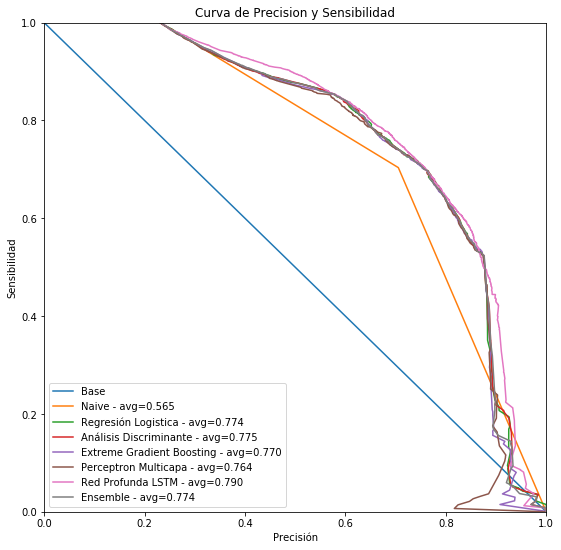

In [157]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
plt.plot([1,0], [0,1], label="Base")
for modelo, probabilidades in models.items():    
    precision, recall, _  = precision_recall_curve(Y_test, probabilidades)
    avg =  average_precision_score(Y_test, probabilidades)
    plt.plot(precision,recall, label='{} - avg={:.3f}'.format(modelo, avg))
plt.legend(loc="lower left")
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel("Precisión")
plt.ylabel("Sensibilidad")
plt.title("Curva de Precision y Sensibilidad")

Text(0.5,1,'Curva ROC')

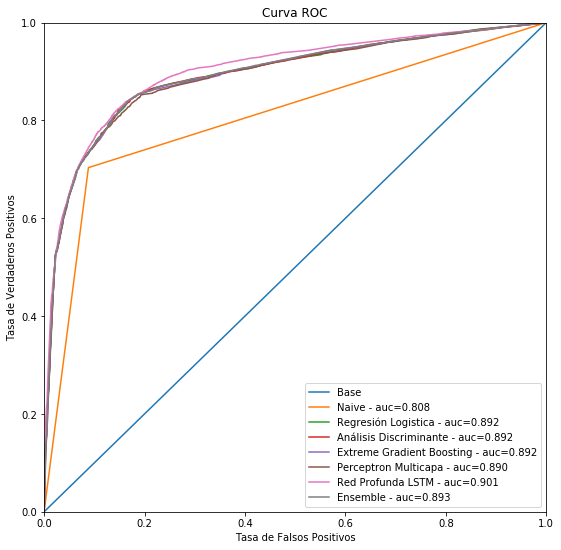

In [156]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
plt.plot([0,1], [0,1], label="Base")
for modelo, probabilidades in models.items():    
    fpr, tpr, _  = roc_curve(Y_test, probabilidades)
    auc = roc_auc_score(Y_test, probabilidades)
    plt.plot(fpr,tpr, label='{} - auc={:.3f}'.format(modelo, auc))
plt.legend(loc="lower right")
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")

In [111]:
lstm_probas = best_model.predict({
                "estructural_input": X_test_estructural.values,
                "pagos_input": X_test_pagos.values
                })

thresholds = np.arange(0,1,0.01)
results = []
for threshold in thresholds:
    preds = lstm_probas > threshold
    results.append([threshold, 
                    accuracy_score(Y_test, preds),
                    precision_score(Y_test, preds),
                    recall_score(Y_test, preds),
                    f1_score(Y_test, preds)])

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [113]:
results_df = pd.DataFrame(results, columns = ["threshold","accuracy","precision","recall","f1"])

In [114]:
results_df.sort_values("f1", ascending=False)

,threshold,accuracy,precision,recall,f1
38,0.38,0.875903,0.733318,0.727760,0.730528
34,0.34,0.872319,0.713729,0.747348,0.730151
36,0.36,0.873989,0.722889,0.737554,0.730148
37,0.37,0.874906,0.728328,0.731724,0.730022
42,0.42,0.878544,0.750739,0.710388,0.730007
41,0.41,0.877897,0.746647,0.714003,0.729960
43,0.43,0.879190,0.755110,0.706424,0.729956
39,0.39,0.876496,0.737908,0.722164,0.729951
35,0.35,0.873046,0.718221,0.741751,0.729796
44,0.44,0.879676,0.759530,0.701527,0.729378


In [142]:
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(
    estimators= [
        ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")),
        ("xgb", xgb2),
        ("mlpc", logReg)
    ],
    voting= "soft"
)

In [143]:
vclf.fit(X_train, Y_train)

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


VotingClassifier(estimators=[('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0219938...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [144]:
train_preds = vclf.predict(X_train)
print("accuracy:", accuracy_score(Y_train, train_preds))
print("precision:", precision_score(Y_train, train_preds))
print("recall:", recall_score(Y_train, train_preds))
print("f1:", f1_score(Y_train, train_preds))
print("--------------------------------------------------")
test_preds = vclf.predict(X_test.values)
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.8783523451246891
precision: 0.8064075923456254
recall: 0.7263254930443042
f1: 0.7642744815625873
--------------------------------------------------
accuracy: 0.8793791096259567
precision: 0.7652995212834778
recall: 0.689635070537484
f1: 0.7254998160186436


C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [148]:
average_precision_score(Y_test, vclf.predict_proba(X_test.values)[1])

ValueError: Found input variables with inconsistent numbers of samples: [37108, 2]

In [124]:
X_train_2 = X_train
X_train_2.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30']

In [132]:
train_preds = vclf.predict(X_train)

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: could not broadcast input array from shape (131848,1) into shape (131848)